In [1]:
import pandas as pd
import requests
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

In [3]:
df_gse16 = f"{assets}/GSE161529/GSE161529_DE_oncogenes.csv"
df_gse18 = f"{assets}/GSE180286/GSE180286_DE_oncogenes.csv"

# Load the datasets and tag with dataset source
df_16 = pd.read_csv(df_gse16)
df_16["Dataset"] = "GSE161529"

df_18 = pd.read_csv(df_gse18)
df_18["Dataset"] = "GSE180286"

# Standardize gene column if needed
df_16["gene"] = df_16["gene"].str.upper()
df_18["gene"] = df_18["gene"].str.upper()

In [4]:
# Combine both
combined_df = pd.concat([df_18, df_16], ignore_index=True)

In [5]:
# Save combined file
combined_df.to_csv(f"{assets}/Combined_DE.csv", index=False)
print("Combined_de_genes.csv created successfully.")

Combined_de_genes.csv created successfully.


In [6]:
# Load DGIdb interaction data and extract druggable genes
dgidb_df = pd.read_csv(f"{assets}/interactions.tsv", sep="\t")

In [7]:
# Filter druggable genes: approved or anti-neoplastic
dgidb_filtered = dgidb_df[
    (dgidb_df["approved"] == True) | (dgidb_df["anti_neoplastic"] == True)
]

# Unique druggable gene symbols (uppercased for consistency)
druggable_genes = dgidb_filtered["gene_name"].dropna().str.upper().unique()
print(f"Number of druggable genes from DGIdb: {len(druggable_genes)}")

Number of druggable genes from DGIdb: 3579


___

___

___

In [8]:
# Query Open Targets API for breast cancer target association scores
url = "https://api.platform.opentargets.org/api/v4/graphql"
query = """
    query BreastCancerTargets($efoId: String!, $size: Int!) {
        disease(efoId: $efoId) {
            associatedTargets(page: { index: 0, size: $size }) {
                rows {
                    target {
                        approvedSymbol
                    }
                    score
                }
            }
        }
    }
"""
variables = {
    "efoId": "EFO_0000305",  # Breast cancer EFO ID
    "size": 500
}

response = requests.post(url, json={"query": query, "variables": variables})
data = response.json()

In [9]:
data

{'data': {'disease': {'associatedTargets': {'rows': [{'target': {'approvedSymbol': 'BRCA2'},
      'score': 0.9015570127068824},
     {'target': {'approvedSymbol': 'BRCA1'}, 'score': 0.8750451744229439},
     {'target': {'approvedSymbol': 'PIK3CA'}, 'score': 0.8559343029703544},
     {'target': {'approvedSymbol': 'PALB2'}, 'score': 0.8550810037606932},
     {'target': {'approvedSymbol': 'TP53'}, 'score': 0.8521601650622082},
     {'target': {'approvedSymbol': 'CHEK2'}, 'score': 0.8323434664299262},
     {'target': {'approvedSymbol': 'CDH1'}, 'score': 0.8296330440284129},
     {'target': {'approvedSymbol': 'ESR1'}, 'score': 0.8245563043802553},
     {'target': {'approvedSymbol': 'ERBB2'}, 'score': 0.8200202466263291},
     {'target': {'approvedSymbol': 'RAD51C'}, 'score': 0.8184892879756712},
     {'target': {'approvedSymbol': 'AKT1'}, 'score': 0.8127212288178087},
     {'target': {'approvedSymbol': 'ATM'}, 'score': 0.810702935283194},
     {'target': {'approvedSymbol': 'BRIP1'}, 'score

In [10]:
rows = data["data"]["disease"]["associatedTargets"]["rows"]

open_targets_df = pd.DataFrame([
    {
        "Gene": row["target"]["approvedSymbol"].upper(),
        "OpenTargets_Score": row["score"]
    }
    for row in rows if row.get("score") is not None
])

In [11]:
# Filter strong breast cancer associations
open_targets_df = open_targets_df[open_targets_df["OpenTargets_Score"] >= 0.5]

print(f"Number of genes strongly associated with breast cancer (Open Targets): {open_targets_df.shape[0]}")

Number of genes strongly associated with breast cancer (Open Targets): 316


In [12]:
open_targets_df.to_csv(f"{assets}/OpenTargets_BreastCancer.csv", index=False)

___

___

___

In [13]:
# Merge DE genes with DGIdb and Open Targets info
# Ensure gene symbols uppercase in DE dataframe for consistency
combined_df["Gene"] = combined_df["gene"].str.upper()

# Add DGIdb Status
combined_df["DGIdb Status"] = combined_df["Gene"].apply(lambda x: "Targeted" if x in druggable_genes else "Not Targeted")

In [14]:
combined_df

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status
0,PTEN,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted
1,CDK4,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted
2,CDKN2A,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted
3,CDKN1A,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted
4,FGFR1,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted
...,...,...,...,...,...,...,...
73,BCL2,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted
74,BRCA2,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted
75,ATM,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted
76,WT1,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted


In [15]:
# Merge with Open Targets scores (left join to keep all DE genes)
df = combined_df.merge(open_targets_df, how="left", left_on="Gene", right_on="Gene")

# Add breast cancer support flags
df["BreastCancer_Supported"] = df["OpenTargets_Score"].notna()
df["Strong_BreastCancer_Support"] = df["OpenTargets_Score"].fillna(0) >= 0.5

In [16]:
df

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support
0,PTEN,0.000000e+00,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True
1,CDK4,0.000000e+00,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True
2,CDKN2A,0.000000e+00,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True
3,CDKN1A,0.000000e+00,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False
4,FGFR1,0.000000e+00,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True
...,...,...,...,...,...,...,...,...,...,...
73,BCL2,6.880750e-252,1.470827,0.060847,GSE161529,BCL2,Targeted,0.542606,True,True
74,BRCA2,6.852575e-238,2.499320,0.025311,GSE161529,BRCA2,Targeted,0.901557,True,True
75,ATM,4.698129e-180,1.058718,0.071020,GSE161529,ATM,Targeted,0.810703,True,True
76,WT1,1.056194e-19,2.424174,0.001583,GSE161529,WT1,Targeted,NaN,False,False


In [17]:
# Add FDA approval info from DGIdb data 
# To get FDA approval status, use the dgidb_filtered dataframe:
# Extract gene-wise FDA approval flag

# Prepare dictionary mapping gene -> FDA approved (True/False)
fda_dict = dgidb_filtered.groupby("gene_name")["approved"].max().to_dict()

# Map it onto df
df["FDA_Approved_Drug"] = df["Gene"].map(fda_dict).fillna(False)
df["FDA_Approved_Drug"] = df["FDA_Approved_Drug"].map({True: "Yes", False: "No"})

In [18]:
# Assign therapeutic categories specific to breast cancer
def assign_targeting_category(row):
    if row["Strong_BreastCancer_Support"]:
        if row["DGIdb Status"] == "Targeted":
            if row["FDA_Approved_Drug"] == "Yes":
                return "FDA-approved for Cancer Therapy"
            else:
                return "Emerging Breast Cancer Target"
        else:
            return "Lacks Breast Cancer Evidence"
    else:
        return "Lacks Breast Cancer Evidence"

df["Targeting Category"] = df.apply(assign_targeting_category, axis=1)

In [19]:
# Save the annotated dataframe
df.to_csv(f"{assets}/Oncogene_therapeutic_stratification.csv", index=False)

In [20]:
# Show some sample rows
df.sample(5)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category
14,AKT1,4.110008e-296,3.674780,0.026305,GSE180286,AKT1,Targeted,0.812721,True,True,Yes,FDA-approved for Cancer Therapy
71,MET,0.000000e+00,3.667057,0.130467,GSE161529,MET,Targeted,0.539556,True,True,Yes,FDA-approved for Cancer Therapy
37,FGFR2,5.517819e-36,3.908594,0.002577,GSE180286,FGFR2,Targeted,0.782859,True,True,Yes,FDA-approved for Cancer Therapy
19,BCL2,1.067443e-238,1.345055,0.054420,GSE180286,BCL2,Targeted,0.542606,True,True,Yes,FDA-approved for Cancer Therapy
35,ATM,4.945179e-48,0.522267,0.029816,GSE180286,ATM,Targeted,0.810703,True,True,Yes,FDA-approved for Cancer Therapy


In [21]:
# Summary of therapeutic categories
df['Targeting Category'].value_counts()

Targeting Category
FDA-approved for Cancer Therapy    62
Lacks Breast Cancer Evidence       14
Emerging Breast Cancer Target       2
Name: count, dtype: int64

In [22]:
# Summary statistics for log2FC by category
df.groupby('Targeting Category')['log2_fc'].describe()

,count,mean,std,min,25%,50%,75%,max
Targeting Category,,,,,,,,
Emerging Breast Cancer Target,2.0,2.299515,0.654421,1.836769,2.068142,2.299515,2.530888,2.762261
FDA-approved for Cancer Therapy,62.0,2.799226,0.997994,0.522267,2.278064,2.645123,3.240478,6.202051
Lacks Breast Cancer Evidence,14.0,2.743829,0.820120,1.202924,2.427948,2.606678,2.906411,4.706735


In [23]:
# List unique genes per category
for cat in df['Targeting Category'].unique():
    genes = df.loc[df['Targeting Category'] == cat, 'gene'].unique()
    print(f"\nCategory: {cat} — {len(genes)} unique genes")
    print(genes)  # print first 10 genes


Category: FDA-approved for Cancer Therapy — 31 unique genes
['PTEN' 'CDK4' 'CDKN2A' 'FGFR1' 'MDM2' 'HRAS' 'FOXO3' 'CCND1' 'ERBB2'
 'KRAS' 'AKT1' 'MYC' 'BRCA1' 'TP53' 'PIK3CA' 'BCL2' 'CDK6' 'RB1' 'NF1'
 'BRCA2' 'ATR' 'SMAD4' 'CHEK2' 'TSC2' 'STK11' 'MET' 'EGFR' 'NOTCH1' 'ATM'
 'NTRK2' 'FGFR2']

Category: Lacks Breast Cancer Evidence — 8 unique genes
['CDKN1A' 'VHL' 'BAX' 'NRAS' 'NF2' 'SRC' 'WT1' 'NTRK1']

Category: Emerging Breast Cancer Target — 1 unique genes
['CASP8']


In [24]:
# Drop duplicates based on 'gene' column, keeping the first occurrence
df_unique = df.drop_duplicates(subset='gene', keep='first').reset_index(drop=True)

In [25]:
# Dynamically find FDA-approved breast cancer genes
fda_bc_specific_genes = df_unique[
    (df_unique["FDA_Approved_Drug"] == "Yes") &
    (df_unique["OpenTargets_Score"].fillna(0) >= 0.5)
]["Gene"].unique().tolist()

print(f"Dynamically found {len(fda_bc_specific_genes)} FDA-approved genes for breast cancer.")
fda_bc_specific_genes

Dynamically found 31 FDA-approved genes for breast cancer.


['PTEN',
 'CDK4',
 'CDKN2A',
 'FGFR1',
 'MDM2',
 'HRAS',
 'FOXO3',
 'CCND1',
 'ERBB2',
 'KRAS',
 'AKT1',
 'MYC',
 'BRCA1',
 'TP53',
 'PIK3CA',
 'BCL2',
 'CDK6',
 'RB1',
 'NF1',
 'BRCA2',
 'ATR',
 'SMAD4',
 'CHEK2',
 'TSC2',
 'STK11',
 'MET',
 'EGFR',
 'NOTCH1',
 'ATM',
 'NTRK2',
 'FGFR2']

In [26]:
# # Filter FDA-approved Breast Cancer Therapy genes and assign subcategories
# df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()

# df_fda['FDA_Subcategory'] = df_fda['Gene'].apply(
#     lambda g: 'FDA-approved for Breast Cancer' if g in fda_bc_specific_genes else 'FDA-approved for Other Cancer/General'
# )

# print("\nFDA Subcategory counts:")
# df_fda['FDA_Subcategory'].value_counts()

In [27]:
# # Combine back with other targeting categories
# df_other = df_unique[df_unique['Targeting Category'] != 'FDA-approved Breast Cancer Therapy'].copy()

# df_final = pd.concat([df_fda, df_other], ignore_index=True)

In [28]:
# Save the updated dataframe
# output_path = "~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_dynamic.csv"
# df_final.to_csv(output_path, index=False)
# print(f"\nSaved file with FDA subcategories: {output_path}")

In [29]:
df_unique.head(1)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category
0,PTEN,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy


In [30]:
bc_approved_genes = [
    'ERBB2', 'CDK4', 'CDK6', 'PIK3CA', 'FGFR1', 'FGFR2', 'EGFR', 'BRCA1', 'BRCA2',
    'TP53', 'AKT1', 'MYC', 'KRAS'
]

def fda_subcategory(row):
    if row['Targeting Category'] != 'FDA-approved for Cancer Therapy':
        return None
    if row['gene'] in bc_approved_genes:
        return 'FDA-approved for Breast Cancer'
    else:
        return 'FDA-approved, Other Indication'

df_unique['FDA_Subcategory'] = df_unique.apply(fda_subcategory, axis=1)
df_unique['FDA_Subcategory'].value_counts()

FDA_Subcategory
FDA-approved, Other Indication    18
FDA-approved for Breast Cancer    13
Name: count, dtype: int64

In [31]:
df_unique.head(5)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,FDA_Subcategory
0,PTEN,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication"
1,CDK4,0.0,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer
2,CDKN2A,0.0,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication"
3,CDKN1A,0.0,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,None
4,FGFR1,0.0,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer


In [32]:
# # Assuming df_unique is your deduplicated dataframe after previous steps

# # Dynamically extract gene lists by category
# fda_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "FDA-approved for Cancer Therapy", "gene"].unique().tolist()
# emerging_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Emerging Cancer Target", "gene"].unique().tolist()
# lacks_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Lacks Cancer Evidence", "gene"].unique().tolist()

# print(f"FDA-approved Breast Cancer Therapy genes ({len(fda_bc_genes)}): {fda_bc_genes}")
# print(f"Emerging Breast Cancer Target genes ({len(emerging_bc_genes)}): {emerging_bc_genes}")
# print(f"Lacks Breast Cancer Evidence genes ({len(lacks_bc_genes)}): {lacks_bc_genes}")

In [33]:
# # Create a new column FDA_Subcategory with subgroups (example below is simple)
# def fda_subcategory(row):
#     if row["gene"] in fda_bc_genes:
#         return "FDA-approved for Breast Cancer"
#     elif row["gene"] in emerging_bc_genes:
#         return "Emerging Breast Cancer Target"
#     elif row["gene"] in lacks_bc_genes:
#         return "Lacks Breast Cancer Evidence"
#     else:
#         return "Other"

# df_unique["Therapeutic Subcategory"] = df_unique.apply(fda_subcategory, axis=1)
# df_unique.head(5)

In [34]:
# 3. If you have pathway info in df_unique or a master file, merge here (assuming pathway column exists)
# If separate master file:
# master_df = pd.read_csv("path_to_master_with_pathways.csv")
# df_unique = df_unique.merge(master_df[['gene', 'Pathway Category']], on='gene', how='left')

# 4. Add drug trial data
# Assuming you have a dataframe trial_df with columns: ['gene', 'Breast Cancer Trial'] (True/False)
# trial_df = pd.read_csv("path_to_trial_info.csv")
# df_unique = df_unique.merge(trial_df, on='gene', how='left')
# Fill missing trial info as False
# df_unique['Breast Cancer Trial'] = df_unique['Breast Cancer Trial'].fillna(False)

# 5. Save the final dataframe
# output_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_extended.csv")
# df_unique.to_csv(output_path, index=False)
# print(f"✅ Saved final annotated therapeutic subcategories with pathways and trials to {output_path}")


In [35]:
# df_unique.head(5)

In [36]:
# To infer Clinical Trial Status from your existing columns related to breast cancer relevance, such as the Open Targets breast cancer trial flags
def clinical_trial_status(row):
    # Define trial status if strongly breast cancer supported or high OpenTargets score
    if pd.notna(row['OpenTargets_Score']) and row['OpenTargets_Score'] >= 0.5:
        return "In Breast Cancer Trial"
    elif row['Strong_BreastCancer_Support']:
        return "In Breast Cancer Trial"
    else:
        return "No Breast Cancer Trial"

In [37]:
df_unique['Clinical_Trial_Status'] = df_unique.apply(clinical_trial_status, axis=1)

In [38]:
df_unique.head(5)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,FDA_Subcategory,Clinical_Trial_Status
0,PTEN,0.0,1.686214,0.081446,GSE180286,PTEN,Targeted,0.774262,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication",In Breast Cancer Trial
1,CDK4,0.0,3.222505,0.089603,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer,In Breast Cancer Trial
2,CDKN2A,0.0,4.279113,0.062919,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved for Cancer Therapy,"FDA-approved, Other Indication",In Breast Cancer Trial
3,CDKN1A,0.0,3.952025,0.123942,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,None,No Breast Cancer Trial
4,FGFR1,0.0,4.152696,0.070191,GSE180286,FGFR1,Targeted,0.501992,True,True,Yes,FDA-approved for Cancer Therapy,FDA-approved for Breast Cancer,In Breast Cancer Trial


In [39]:
# output_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv"
# df_unique.to_csv(output_path, index=False)
# print(f"✅ Saved annotated file with clinical trial status to {output_path}")

In [40]:
# Quick check of the columns and sample data
df_unique.columns

Index(['gene', 'p_value', 'log2_fc', 'mean_diff', 'Dataset', 'Gene',
       'DGIdb Status', 'OpenTargets_Score', 'BreastCancer_Supported',
       'Strong_BreastCancer_Support', 'FDA_Approved_Drug',
       'Targeting Category', 'FDA_Subcategory', 'Clinical_Trial_Status'],
      dtype='object')

In [41]:
df_unique[['Gene', 'Targeting Category', 'Clinical_Trial_Status']].head(10)

,Gene,Targeting Category,Clinical_Trial_Status
0,PTEN,FDA-approved for Cancer Therapy,In Breast Cancer Trial
1,CDK4,FDA-approved for Cancer Therapy,In Breast Cancer Trial
2,CDKN2A,FDA-approved for Cancer Therapy,In Breast Cancer Trial
3,CDKN1A,Lacks Breast Cancer Evidence,No Breast Cancer Trial
4,FGFR1,FDA-approved for Cancer Therapy,In Breast Cancer Trial
5,MDM2,FDA-approved for Cancer Therapy,In Breast Cancer Trial
6,HRAS,FDA-approved for Cancer Therapy,In Breast Cancer Trial
7,CASP8,Emerging Breast Cancer Target,In Breast Cancer Trial
8,VHL,Lacks Breast Cancer Evidence,No Breast Cancer Trial
9,FOXO3,FDA-approved for Cancer Therapy,In Breast Cancer Trial


In [42]:
# If needed, fill missing trial status (safe practice)
df_unique['Clinical_Trial_Status'] = df_unique['Clinical_Trial_Status'].fillna('No Breast Cancer Trial')

# Example: Summary counts by Clinical Trial Status and Targeting Category
summary = df_unique.groupby(['Targeting Category', 'Clinical_Trial_Status']).size().reset_index(name='counts')
summary

,Targeting Category,Clinical_Trial_Status,counts
0,Emerging Breast Cancer Target,In Breast Cancer Trial,1
1,FDA-approved for Cancer Therapy,In Breast Cancer Trial,31
2,Lacks Breast Cancer Evidence,No Breast Cancer Trial,8


In [43]:
# Sankey Plot Code: Therapeutic Categories → Clinical Trial Status → Genes
# Deduplicate on gene to avoid repeats in plot
df_unique = df_unique.drop_duplicates(subset=["gene", "Targeting Category", "Clinical_Trial_Status"]).copy()

# Define major nodes (categories and trial statuses)
categories = df_unique["Targeting Category"].unique().tolist()
trial_statuses = df_unique["Clinical_Trial_Status"].unique().tolist()
genes = df_unique["gene"].unique().tolist()

# Combine all nodes in order
label_list = categories + trial_statuses + genes

In [44]:
# Create a dict to map label to index
label_to_idx = {label: i for i, label in enumerate(label_list)}

# Prepare sankey links
source = []
target = []
value = []
colors = []

# Color palette (you can customize)
category_colors = {
    "FDA-approved for Cancer Therapy": "green",
    "Emerging Breast Cancer Target": "orange",
    "Lacks Breast Cancer Evidence": "red",
}
trial_colors = {
    "In Breast Cancer Trial": "blue",
    "No Breast Cancer Trial": "gray",
}

In [45]:
# Links from Categories → Clinical Trial Status
for cat in categories:
    for trial in trial_statuses:
        count = df_unique[
            (df_unique["Targeting Category"] == cat) &
            (df_unique["Clinical_Trial_Status"] == trial)
        ].shape[0]
        if count > 0:
            source.append(label_to_idx[cat])
            target.append(label_to_idx[trial])
            value.append(count)
            colors.append(category_colors.get(cat, "lightgray"))

# Links from Clinical Trial Status → Genes
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row["Clinical_Trial_Status"]])
    target.append(label_to_idx[row["gene"]])
    value.append(1)
    colors.append(trial_colors.get(row["Clinical_Trial_Status"], "lightgray"))

# Node colors: categories and trial statuses get colored, genes are light gray
node_colors = []
for label in label_list:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in trial_colors:
        node_colors.append(trial_colors[label])
    else:
        node_colors.append("lightgray")

In [46]:
# Build Sankey figure
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
))

fig.update_layout(
    title_text="Therapeutic Categories and Clinical Trial Status Sankey Diagram",
    font_size=12,
    height=600,
    width=1100
)

fig.show()

In [47]:
gene_to_pathway = {
    'CDK4': 'CDK4–CCND1 Axis',
    'CCND1': 'CDK4–CCND1 Axis',
    'CDKN2A': 'Cell Cycle & Apoptosis',
    'TP53': 'DNA Repair / Tumor Suppressors',
    'BRCA1': 'DNA Repair / Tumor Suppressors',
    'BRCA2': 'DNA Repair / Tumor Suppressors',
    'EGFR': 'PI3K–MAPK–EGFR',
    'KRAS': 'RAS Pathway',
    'NRAS': 'RAS Pathway',
    'HRAS': 'RAS Pathway',
    'PIK3CA': 'PI3K–MAPK–EGFR',
    'PTEN': 'PI3K–MAPK–EGFR',
    'MYC': 'MYC Axis',
    'FGFR1': 'RTKs / Growth Factor Signaling',
    'FGFR2': 'RTKs / Growth Factor Signaling',
    'ATM': 'DNA Repair / Tumor Suppressors',
    'CHEK2': 'DNA Repair / Tumor Suppressors',
    'MDM2': 'Cell Cycle & Apoptosis',
    'WT1': 'Transcription Factors',
    'CDKN1A': 'Cell Cycle & Apoptosis',
    'BAX': 'Apoptosis',
    'SRC': 'RTKs / Growth Factor Signaling',
    'NF2': 'Tumor Suppressor',
    'VHL': 'Tumor Suppressor',
    'NTRK1': 'RTKs / Growth Factor Signaling',
    'NTRK2': 'RTKs / Growth Factor Signaling'
}

In [48]:
# Now apply this single dictionary to your dataframe
df_unique['Pathway Category'] = df_unique['gene'].map(gene_to_pathway).fillna('Other')

print("Updated unique pathway categories:")
df_unique['Pathway Category'].value_counts()

Updated unique pathway categories:


Pathway Category
Other                             14
RTKs / Growth Factor Signaling     5
DNA Repair / Tumor Suppressors     5
PI3K–MAPK–EGFR                     3
Cell Cycle & Apoptosis             3
RAS Pathway                        3
CDK4–CCND1 Axis                    2
Tumor Suppressor                   2
Apoptosis                          1
MYC Axis                           1
Transcription Factors              1
Name: count, dtype: int64

In [49]:
# Define node groups
targeting_cats = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trials = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

# Build label list and mapping
labels = targeting_cats + pathways + trials + genes
label_to_idx = {label: idx for idx, label in enumerate(labels)}

In [50]:
# Define colors for Targeting Categories
targeting_colors_map = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

# Define colors for Pathways (choose a palette)
pathway_palette = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
                    '#f7b6d2', '#dbdb8d', '#9edae5', '#393b79']
pathway_colors_map = {path: pathway_palette[i % len(pathway_palette)] for i, path in enumerate(pathways)}

# Colors for Clinical Trial Status
trial_colors_map = {
    'In Breast Cancer Trial': '#8c564b',  # Brown shade
    'No Breast Cancer Trial': '#7f7f7f'   # Gray shade
}

# Assign node colors
node_colors = []
for label in labels:
    if label in targeting_colors_map:
        node_colors.append(targeting_colors_map[label])
    elif label in pathway_colors_map:
        node_colors.append(pathway_colors_map[label])
    elif label in trial_colors_map:
        node_colors.append(trial_colors_map[label])
    else:
        node_colors.append('lightgray')  # genes or unknowns

In [51]:
# Prepare links as before
source = []
target = []
value = []
link_colors = []

# Category -> Pathway
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['Pathway Category']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Targeting Category']]])  # link colored by source

# Pathway -> Trial
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Pathway Category']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Pathway Category']]])  # link colored by source

# Trial -> Gene (color by expression log2FC)
max_abs_fc = max(abs(df_unique['log2_fc'].min()), abs(df_unique['log2_fc'].max()))

def fc_to_color(fc):
    norm = (fc + max_abs_fc) / (2 * max_abs_fc)
    r = int(255 * norm)
    b = int(255 * (1 - norm))
    return f'rgba({r},0,{b},0.8)'

for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(fc_to_color(row['log2_fc']))

In [52]:
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Add color legend as annotation block (top left corner)
fig.update_layout(
    title_text="Multi-layer Therapeutic Stratification Sankey with Expression Coloring",
    font_size=12,
    height=600,
    width=1100,
    annotations=[
        dict(
            x=0.02, y=0.95, xref='paper', yref='paper',
            text="<b>Color Legend</b><br>" +
                    "<span style='color:green'>&#9632;</span> FDA-approved Breast Cancer Therapy<br>" +
                    "<span style='color:orange'>&#9632;</span> Emerging Breast Cancer Target<br>" +
                    "<span style='color:red'>&#9632;</span> Lacks Breast Cancer Evidence<br>" +
                    "<span style='color:#8c564b'>&#9632;</span> In Breast Cancer Trial<br>" +
                    "<span style='color:#7f7f7f'>&#9632;</span> No Breast Cancer Trial<br>" +
                    "<br><b>Gene Link Color</b><br>" +
                    "<span style='color:red'>&#8594;</span> Upregulated (High log2FC)<br>" +
                    "<span style='color:blue'>&#8594;</span> Downregulated (Low log2FC)",
            showarrow=False,
            font=dict(size=12),
            align="left",
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=5
        )
    ]
)

fig.show()

In [53]:
# Assuming df_unique is your dataframe with these columns:

# Prepare size and color columns
df_unique['abs_log2_fc'] = df_unique['log2_fc'].abs()

# Create bubble plot
fig = px.scatter(
    df_unique,
    x='Targeting Category',            # categories on x-axis
    y='Pathway Category',                    # pathways on y-axis
    size='abs_log2_fc',                      # bubble size = magnitude of expression change
    color='Clinical_Trial_Status',           # color by trial status
    hover_name='gene',                       # hover shows gene name
    size_max=30,
    title='Gene Expression Bubble Plot by Therapeutic Subcategory, Pathway, and Clinical Trial Status',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Cancer Therapy",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ],
        # You can also specify order for pathways if desired
    }
)

fig.update_layout(
    xaxis_title='Therapeutic Subcategory',
    yaxis_title='Pathway Category',
    legend_title='Clinical Trial Status'
)

fig.show()

In [54]:
fig = px.bar(
    df_unique.sort_values('log2_fc', ascending=False),
    x='gene',
    y='log2_fc',
    color='Clinical_Trial_Status',
    facet_col='Targeting Category',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Cancer Therapy",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ]
    },
    labels={
        'gene': 'Gene',
        'log2_fc': 'Log2 Fold Change',
        'Clinical_Trial_Status': 'Clinical Trial Status'
    },
    title='Gene Expression Log2 Fold Change by Therapeutic Subcategory and Clinical Trial Status',
    height=500,
    width=1100  # Increased width for better horizontal spacing
)

fig.update_layout(
    xaxis_tickangle=-45,   # Less rotation to save vertical space
    xaxis_tickfont=dict(size=10),
    legend_title_text='Clinical Trial Status',
    legend=dict(y=0.98, yanchor='top', x=1.02, xanchor='left'),
    margin=dict(t=70, b=80),
    # Reduce space between facets
    grid=dict(columns=3, rows=1),
    # Adjust facet subplot spacing
    uniformtext_minsize=10, 
    uniformtext_mode='hide'
)

# Make y-axis same range across facets
fig.update_yaxes(matches='y')

# Clean facet titles (remove 'Therapeutic Subcategory=')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

In [55]:
# fig.update_layout(
#     width=1000,  # Increase width for more spacing
#     height=600,
#     xaxis=dict(
#         title="Therapeutic Subcategory",
#         categoryorder='array',
#         categoryarray=['FDA-approved for Cancer Therapy', 'Emerging Breast Cancer Target', 'Lacks Breast Cancer Evidence']
#     ),
#     yaxis=dict(
#         title="Pathway Category",
#         categoryorder='array',
#         categoryarray=[
#             'CDK4–CCND1 Axis', 'PI3K–MAPK–EGFR', 'MYC Axis', 'Cell Cycle & Apoptosis',
#             'RAS Pathway', 'RTKs / Growth Factor Signaling', 'Tumor Suppressor',
#             'DNA Repair / Tumor Suppressors', 'Apoptosis', 'Transcription Factors', 'Other'
#         ]
#     ),
#     legend=dict(
#         title="Expression Direction",
#         font=dict(size=12)
#     ),
#     title=dict(
#         text="Gene Expression Bubble Plot by Therapeutic Subcategory and Pathway",
#         font=dict(size=16)
#     )
# )

# fig.show()

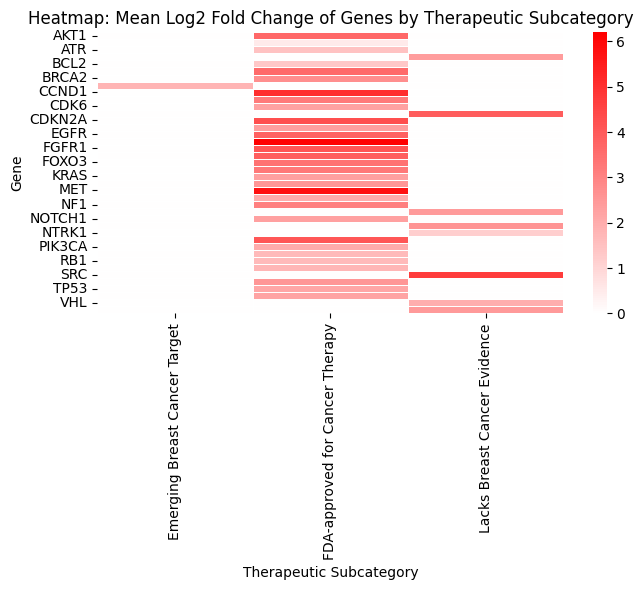

In [56]:
# Prepare pivot table: genes on y-axis, categories/pathways on x-axis, colored by mean log2FC
heatmap_data = df_unique.pivot_table(
    index='gene',
    columns='Targeting Category',  # or 'Pathway Category'
    values='log2_fc',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(7, 6))
sns.heatmap(heatmap_data, cmap='bwr', center=0, linewidths=0.5)
plt.title("Heatmap: Mean Log2 Fold Change of Genes by Therapeutic Subcategory")
plt.ylabel('Gene')
plt.xlabel('Therapeutic Subcategory')
plt.tight_layout()
plt.show()

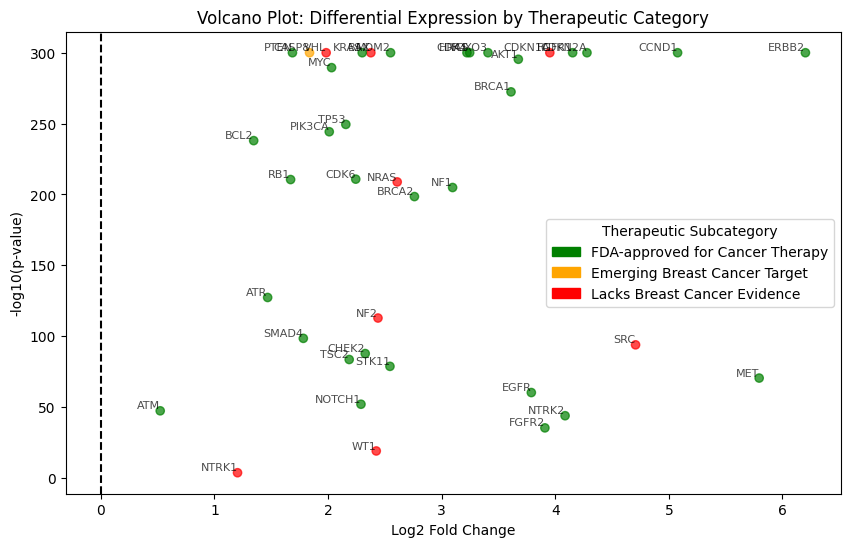

In [57]:
df_unique['-log10_pval'] = -np.log10(df_unique['p_value'] + 1e-300)  # avoid log(0)
plt.figure(figsize=(10, 6))

# Map colors
color_map = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
colors = df_unique['Targeting Category'].map(color_map)

scatter = plt.scatter(df_unique['log2_fc'], df_unique['-log10_pval'],
                        c=colors, alpha=0.7)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Differential Expression by Therapeutic Category')
plt.axvline(0, color='black', linestyle='--')

# Annotate each point with gene name
for i, row in df_unique.iterrows():
    plt.text(row['log2_fc'], row['-log10_pval'], row['gene'],
                fontsize=8, alpha=0.7, ha='right', va='bottom')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, title="Therapeutic Subcategory", loc='center right')

plt.show()

In [58]:
# # Suppose you have a list of genes with FDA-approved drugs specifically for breast cancer
# # This list can come from your manual curation or a trusted source.
# bc_approved_genes = [
#     'ERBB2', 'CDK4', 'CDK6', 'PIK3CA', 'FGFR1', 'FGFR2', 'EGFR', 'BRCA1', 'BRCA2',
#     'TP53', 'AKT1', 'MYC', 'KRAS'  # example subset — replace with your verified list
# ]

# def fda_subcategory(row):
#     if row['Targeting Category'] != 'FDA-approved Breast Cancer Therapy':
#         return None
#     if row['gene'] in bc_approved_genes:
#         return 'FDA-approved for Breast Cancer'
#     else:
#         return 'FDA-approved, Other Indication'

# df_unique['FDA_Subcategory'] = df_unique.apply(fda_subcategory, axis=1)
# print(df_unique['FDA_Subcategory'].value_counts())


In [59]:
# Fill NAs for non-FDA approved
df_unique['FDA_Subcategory'] = df_unique['FDA_Subcategory'].fillna('N/A')

# Build label list for nodes
targeting_categories = df_unique['Targeting Category'].unique().tolist()
fda_subcats = df_unique['FDA_Subcategory'].unique().tolist()
trial_status = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

labels = targeting_categories + fda_subcats + trial_status + genes
label_to_idx = {label: i for i, label in enumerate(labels)}

In [60]:
# Colors for categories (customize as needed)
cat_colors = {
    'FDA-approved for Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red',
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'N/A': 'lightgrey',
    'In Breast Cancer Trial': 'blue',
    'No Breast Cancer Trial': 'grey'
}

# Build links lists: source, target, value, colors
source = []
target = []
value = []
link_colors = []

# Helper function to get color for links (source node color)
def get_link_color(src_label):
    return cat_colors.get(src_label, 'lightgrey')

# Targeting Category → FDA Subcategory
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['FDA_Subcategory']])
    value.append(1)
    link_colors.append(get_link_color(row['Targeting Category']))

# FDA Subcategory → Clinical Trial Status
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['FDA_Subcategory']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(get_link_color(row['FDA_Subcategory']))

# Clinical Trial Status → Gene
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(get_link_color(row['Clinical_Trial_Status']))

In [61]:
# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        color=[cat_colors.get(lbl, 'lightgrey') for lbl in labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text="Therapeutic Stratification with FDA Subcategories", font_size=12, height=800, width=1200)
fig.show()

In [62]:
# # Filter only FDA-approved genes (both subgroups)
# fda_genes = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy']

# # Group by FDA_Subcategory and Clinical_Trial_Status, count genes
# trial_counts = fda_genes.groupby(['FDA_Subcategory', 'Clinical_Trial_Status'])['gene'].nunique().unstack(fill_value=0)

# trial_counts

In [63]:
# Filter subsets for each therapeutic group
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved for Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

# For FDA, use 'FDA_Subcategory' as hue
# For emerging and lacks, assign Therapeutic Group label for hue
df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']

df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine all into one DataFrame for plotting
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True).sort_values(by='log2_fc', ascending=False)

# Define color palette
palette = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

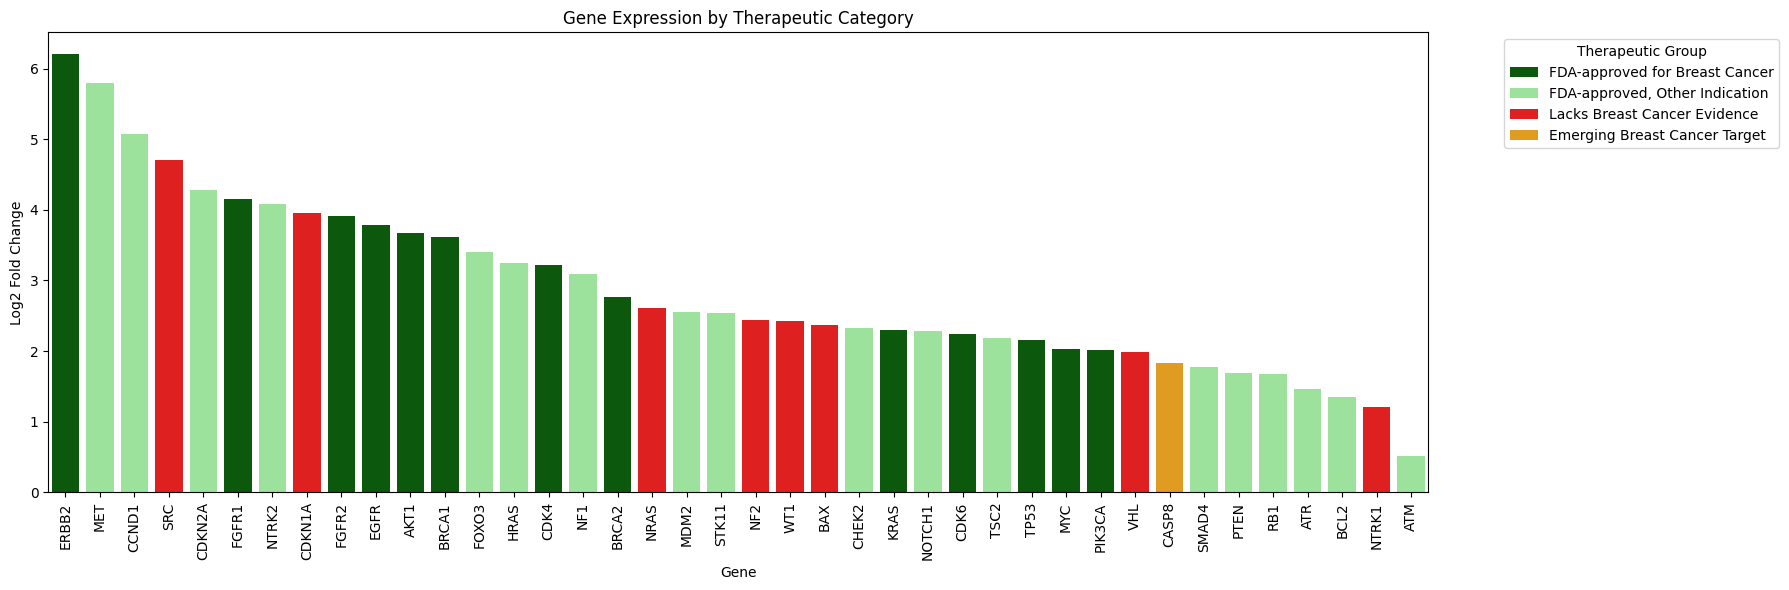

In [64]:
plt.figure(figsize=(18, 6))
sns.barplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    hue='Therapeutic Group',
    dodge=False,
    palette=palette
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression by Therapeutic Category')
plt.legend(title='Therapeutic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
# Filter genes by therapeutic category
genes_fda_bc = df_unique.loc[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy', 'gene'].unique().tolist()

genes_fda_other = df_unique.loc[df_unique['FDA_Subcategory'] == 'FDA-approved, Other Indication', 'gene'].unique().tolist()

genes_emerging = df_unique.loc[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target', 'gene'].unique().tolist()

genes_lacks = df_unique.loc[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence', 'gene'].unique().tolist()

print("FDA-approved Breast Cancer Therapy genes:", genes_fda_bc)
print("FDA-approved Other Indication genes:", genes_fda_other)
print("Emerging Breast Cancer Target genes:", genes_emerging)
print("Lacks Breast Cancer Evidence genes:", genes_lacks)

FDA-approved Breast Cancer Therapy genes: []
FDA-approved Other Indication genes: ['PTEN', 'CDKN2A', 'MDM2', 'HRAS', 'FOXO3', 'CCND1', 'BCL2', 'RB1', 'NF1', 'ATR', 'SMAD4', 'CHEK2', 'TSC2', 'STK11', 'MET', 'NOTCH1', 'ATM', 'NTRK2']
Emerging Breast Cancer Target genes: ['CASP8']
Lacks Breast Cancer Evidence genes: ['CDKN1A', 'VHL', 'BAX', 'NRAS', 'NF2', 'SRC', 'WT1', 'NTRK1']


In [66]:
print(df_unique['Targeting Category'].unique())

['FDA-approved for Cancer Therapy' 'Lacks Breast Cancer Evidence'
 'Emerging Breast Cancer Target']


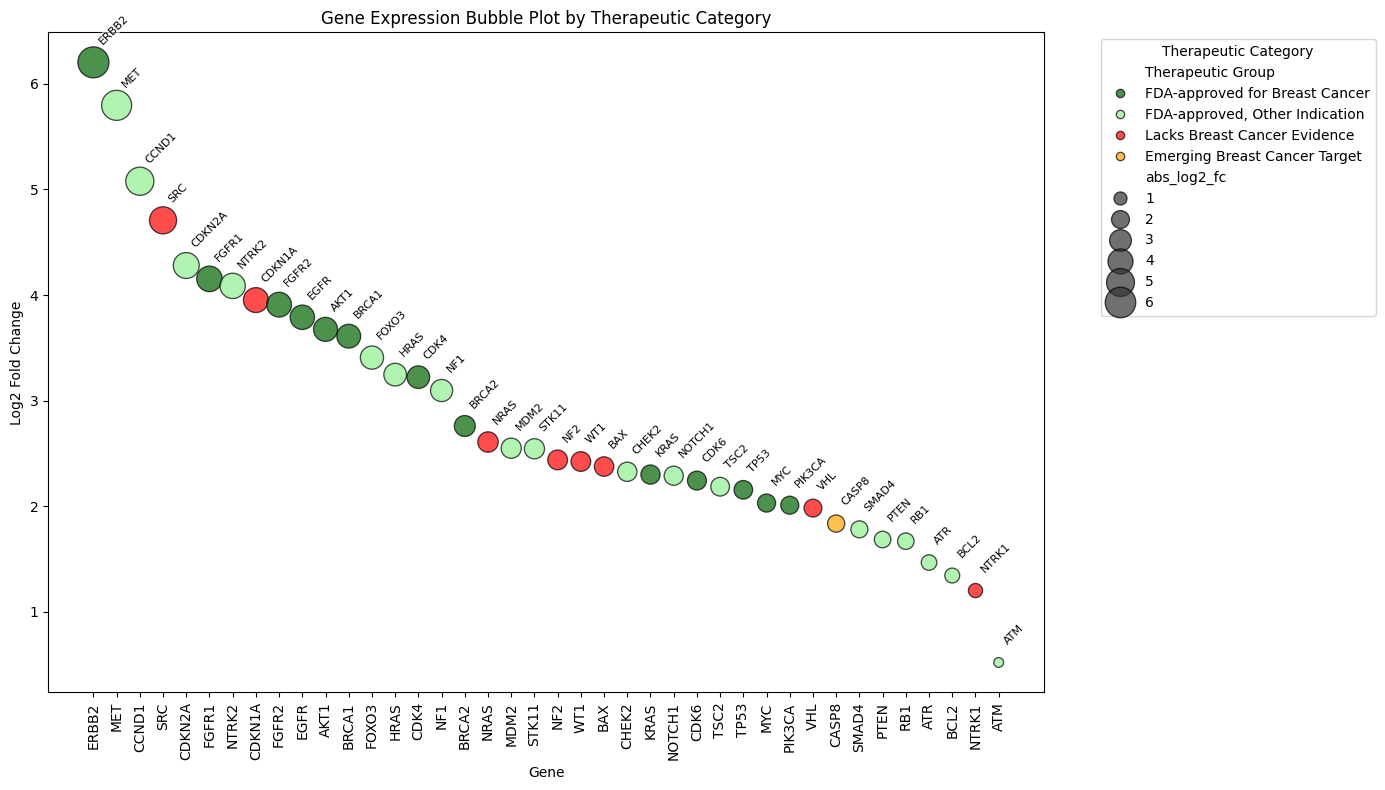

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Prepare absolute log2 fold change for bubble size
df_plot['abs_log2_fc'] = df_plot['log2_fc'].abs()

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    size='abs_log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'darkgreen',
        'FDA-approved, Other Indication': 'lightgreen',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
    },
    sizes=(50, 500),
    alpha=0.7,
    edgecolor='black',
    legend='brief'  # only hue legend
)

# Adjust legend to show only therapeutic group (hue)
handles, labels = scatter.get_legend_handles_labels()
if labels[0] == 'abs_log2_fc':
    handles = handles[1:]
    labels = labels[1:]

plt.legend(handles, labels, title='Therapeutic Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression Bubble Plot by Therapeutic Category')

# Annotate gene names slightly above and to the right of each bubble with background box
for i in range(df_plot.shape[0]):
    plt.text(
        x=i + 0.15,  # shift slightly right
        y=df_plot['log2_fc'].iloc[i] + 0.15,  # shift slightly above
        s=df_plot['gene'].iloc[i],
        fontsize=8,
        rotation=45,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

plt.tight_layout()
plt.show()






In [68]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Example DataFrame structure (adjust with your df_unique):

# Assuming df_unique, df_fda, df_emerging, df_lacks are already defined as you shared

# Prepare Therapeutic Group as in your bar plot code:
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']
df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)
print(df_plot.head(5))
# Create label list for nodes (Therapeutic Group, Pathway Category, Clinical Trial, Gene)
labels_therapeutic = df_plot['Therapeutic Group'].unique().tolist()
labels_pathway = df_plot['Pathway Category'].unique().tolist()
labels_trial = df_plot['Clinical_Trial_Status'].unique().tolist()
labels_genes = df_plot['gene'].unique().tolist()

labels = labels_therapeutic + labels_pathway + labels_trial + labels_genes

# Map label to index
label_to_idx = {label: idx for idx, label in enumerate(labels)}

def get_links(source_col, target_col):
    link_df = df_plot.groupby([source_col, target_col]).size().reset_index(name='count')
    sources = link_df[source_col].map(label_to_idx).tolist()
    targets = link_df[target_col].map(label_to_idx).tolist()
    values = link_df['count'].tolist()
    return sources, targets, values

# Links for Sankey
source_1, target_1, value_1 = get_links('Therapeutic Group', 'Pathway Category')
source_2, target_2, value_2 = get_links('Pathway Category', 'Clinical_Trial_Status')
source_3, target_3, value_3 = get_links('Clinical_Trial_Status', 'gene')

sources = source_1 + source_2 + source_3
targets = target_1 + target_2 + target_3
values = value_1 + value_2 + value_3

# Color nodes by Therapeutic Group for clarity (optional)
color_map = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
node_colors = []
for label in labels:
    # If therapeutic group, assign color, else default light grey
    node_colors.append(color_map.get(label, 'lightgrey'))

# Color gene links by log2 fold change (blue for down, red for up)
def logfc_to_color(logfc):
    # Normalize logFC for color intensity
    max_val = max(abs(df_plot['log2_fc'].max()), abs(df_plot['log2_fc'].min()))
    norm_val = logfc / max_val
    if norm_val >= 0:
        # Red shades for upregulated
        return f'rgba(255, 0, 0, {0.3 + 0.7 * norm_val})'
    else:
        # Blue shades for downregulated
        return f'rgba(0, 0, 255, {0.3 + 0.7 * abs(norm_val)})'

# Map genes to colors by log2_fc
gene_color_map = dict(zip(df_plot['gene'], df_plot['log2_fc'].apply(logfc_to_color)))

link_colors = []
for i in range(len(sources)):
    # For links from Clinical Trial Status to Gene, use gene color
    if sources[i] in [label_to_idx[t] for t in labels_trial] and targets[i] in [label_to_idx[g] for g in labels_genes]:
        gene_label = labels[targets[i]]
        link_colors.append(gene_color_map.get(gene_label, 'lightgrey'))
    else:
        link_colors.append('lightgrey')

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        hovertemplate='%{value} genes<br>From %{source.label} to %{target.label}<extra></extra>'
    )
)])

fig.update_layout(title_text='Therapeutic Stratification Sankey with Log2FC Coloring on Gene Links',
                  font_size=10)

fig.show()




     gene        p_value   log2_fc  mean_diff    Dataset    Gene DGIdb Status  \
0   CASP8   0.000000e+00  1.836769   0.054656  GSE180286   CASP8     Targeted   
1  CDKN1A   0.000000e+00  3.952025   0.123942  GSE180286  CDKN1A     Targeted   
2     VHL   0.000000e+00  1.983113   0.048900  GSE180286     VHL     Targeted   
3     BAX   0.000000e+00  2.376556   0.154106  GSE180286     BAX     Targeted   
4    NRAS  1.466673e-209  2.608673   0.022918  GSE180286    NRAS     Targeted   

   OpenTargets_Score  BreastCancer_Supported  Strong_BreastCancer_Support  \
0           0.581988                    True                         True   
1                NaN                   False                        False   
2                NaN                   False                        False   
3                NaN                   False                        False   
4                NaN                   False                        False   

  FDA_Approved_Drug             Targeting Category

In [69]:
# Show genes grouped by clinical trial status and therapeutic group
trial_summary = df_plot[['gene', 'Clinical_Trial_Status', 'Therapeutic Group']].copy()

# Sort by Clinical Trial Status and Therapeutic Group
trial_summary = trial_summary.sort_values(by=['Clinical_Trial_Status', 'Therapeutic Group', 'gene'])

# Print summary
print(trial_summary.to_string(index=False))


  gene  Clinical_Trial_Status             Therapeutic Group
 CASP8 In Breast Cancer Trial Emerging Breast Cancer Target
   BAX No Breast Cancer Trial  Lacks Breast Cancer Evidence
CDKN1A No Breast Cancer Trial  Lacks Breast Cancer Evidence
   NF2 No Breast Cancer Trial  Lacks Breast Cancer Evidence
  NRAS No Breast Cancer Trial  Lacks Breast Cancer Evidence
 NTRK1 No Breast Cancer Trial  Lacks Breast Cancer Evidence
   SRC No Breast Cancer Trial  Lacks Breast Cancer Evidence
   VHL No Breast Cancer Trial  Lacks Breast Cancer Evidence
   WT1 No Breast Cancer Trial  Lacks Breast Cancer Evidence


___

___

___

# Redesign required below

___

In [70]:
import requests

# This is a conceptual URL, you'll need to check the official API documentation for the exact endpoint and parameters.
# The URL and parameters are likely correct for the v2.0 API.
api_url = "https://clinicaltrials.gov/api/v2/studies"
params = {
    "query.term": "cancer AND CASP8",
    "fields": "NCTId,BriefTitle,Condition", # You can also specify nested fields here
    "pageSize": 100 
}

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()

    data = response.json()
    studies = data.get("studies", [])

    for study in studies:
        # Accessing nested fields correctly
        identification_module = study.get("protocolSection", {}).get("identificationModule", {})
        
        nct_id = identification_module.get("nctId") # Note the lowercase "n" in nctId
        title = study.get("protocolSection", {}).get("identificationModule", {}).get("briefTitle")
        condition = study.get("protocolSection", {}).get("designModule", {}).get("conditions", [None])[0]

        # Process the data as needed
        if nct_id and title:
            print(f"NCT ID: {nct_id}, Title: {title}")
        else:
            print("Study record missing key data.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A KeyError occurred. The key {e} was not found in the study data.")

NCT ID: NCT01440413, Title: Study of the Response to a Neoadjuvant Chemotherapy Based on the Antitumor Immune Response in Localized Breast Cancer
NCT ID: NCT01529307, Title: First in Human Trial of TAS266 in Patients With Advanced Solid Tumors
NCT ID: NCT00458809, Title: Intraperitoneal Hyperthermic Perfusion With Oxaliplatin in Treating Patients With Stage IV Peritoneal Cancer Due to Appendix Cancer or Colorectal Cancer
NCT ID: NCT03877159, Title: Analysis of the Variation in Caspase-8 Availability and Cleavage in Oral Squamous Cell Carcinoma
NCT ID: NCT03059615, Title: A Phase 2a, Open-Label, Two Stage Study of Nerofe or Nerofe With Doxorubicin in Subjects With AML or MDS
NCT ID: NCT05042531, Title: Clinical Research for Azacitidine Combined With Low-dose Dasatinib in Maintenance Therapy of Acute Myeloid Leukemia
NCT ID: NCT00075634, Title: Decitabine, Doxorubicin, and Cyclophosphamide in Treating Children With Relapsed or Refractory Solid Tumors or Neuroblastoma
NCT ID: NCT06626971,

In [71]:
import requests

# This is a conceptual URL, you'll need to check the official API documentation for the exact endpoint and parameters.
# The URL and parameters are likely correct for the v2.0 API.
api_url = "https://clinicaltrials.gov/api/v2/studies"
params = {
    "query.term": "cancer AND FOXO3",
    "fields": "NCTId,BriefTitle,Condition", # You can also specify nested fields here
    "pageSize": 100 
}

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()

    data = response.json()
    studies = data.get("studies", [])

    for study in studies:
        # Accessing nested fields correctly
        identification_module = study.get("protocolSection", {}).get("identificationModule", {})
        
        nct_id = identification_module.get("nctId") # Note the lowercase "n" in nctId
        title = study.get("protocolSection", {}).get("identificationModule", {}).get("briefTitle")
        condition = study.get("protocolSection", {}).get("designModule", {}).get("conditions", [None])[0]

        # Process the data as needed
        if nct_id and title:
            print(f"NCT ID: {nct_id}, Title: {title}")
        else:
            print("Study record missing key data.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A KeyError occurred. The key {e} was not found in the study data.")


NCT ID: NCT03473327, Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
NCT ID: NCT06055634, Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
NCT ID: NCT02968888, Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
NCT ID: NCT03033953, Title: Effects of Native Whey or Milk Supplementation on Adaptations to 12 Weeks of Strength Training in Young and Elderly
NCT ID: NCT03649698, Title: Exercise and Nutrition for Healthy AgeiNg


In [72]:
import requests
import json
import time

# Define the genes and their categories as provided by the user.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene and 'cancer'.
    
    Args:
        gene_name (str): The gene to search for.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    search_query = f"cancer AND {gene_name}"
    
    # The API request parameters. query.term is the search expression.
    params = {
        "query.term": search_query,
        "pageSize": 100 # Retrieve up to 100 studies per call.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        # The studies are in a list under the 'studies' key.
        if 'studies' in data:
            studies = data['studies']
            print(f"-> Found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def filter_and_display_studies(studies, gene_name):
    """
    Filters and displays studies that explicitly mention the gene name.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name to filter by.
    """
    found_studies = []
    for study in studies:
        # We'll create a single searchable string from all text values to be robust.
        study_text = json.dumps(study).lower()
        
        if gene_name.lower() in study_text:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            
            # Append to the list of found studies.
            found_studies.append({
                "NCT ID": nct_id,
                "Title": study_title
            })
            
    return found_studies

# Main execution loop to analyze all genes.
all_results = {}
for category, genes in gene_categories.items():
    print(f"\n=======================================================")
    print(f"Analyzing genes in category: '{category}'")
    print(f"=======================================================")
    
    all_results[category] = {}
    for gene in genes:
        print(f"\n--- Processing gene: {gene} ---")
        studies_data = search_studies_for_gene(gene)
        
        if studies_data:
            filtered_studies = filter_and_display_studies(studies_data, gene)
            all_results[category][gene] = filtered_studies
            
            if filtered_studies:
                print(f"-> Found {len(filtered_studies)} studies explicitly mentioning '{gene}':")
                for study in filtered_studies:
                    print(f"   - NCT ID: {study['NCT ID']} | Title: {study['Title']}")
            else:
                print(f"-> No studies found explicitly mentioning '{gene}' in the full data.")
        
        # Adding a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF FINDINGS")
print("="*50)
for category, genes_data in all_results.items():
    print(f"\nCategory: {category}")
    for gene, studies in genes_data.items():
        if studies:
            print(f"  - Gene '{gene}': {len(studies)} studies found.")
        else:
            print(f"  - Gene '{gene}': No studies found.")
print("="*50)




Analyzing genes in category: 'Emerging Breast Cancer Target'

--- Processing gene: CASP8 ---
Searching for studies with query: 'cancer AND CASP8'...
-> Found 10 total studies for 'cancer AND CASP8'.
-> No studies found explicitly mentioning 'CASP8' in the full data.

--- Processing gene: FOXO3 ---
Searching for studies with query: 'cancer AND FOXO3'...
-> Found 5 total studies for 'cancer AND FOXO3'.
-> Found 4 studies explicitly mentioning 'FOXO3':
   - NCT ID: NCT03473327 | Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
   - NCT ID: NCT06055634 | Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
   - NCT ID: NCT02968888 | Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
   - NCT ID: NCT03649698 | Title: Exercise and Nutrition for Healthy AgeiNg

Analyzing genes in category: 'Lacks Breast Cancer Evidence'

--- Processing gene: CDKN1A ---
Searching 

In [73]:
import requests
import json
import time

# Define the genes and their categories.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# Add a dictionary of known NCT IDs for genes that may not be found by the search function.
known_nct_ids = {
    'CASP8': ['NCT03877159']  # We know this study exists and is relevant.
}

# Base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def get_full_study_by_nctid(nct_id):
    """
    Retrieves a single study record directly by its NCT ID.
    This bypasses the search functionality.
    
    Args:
        nct_id (str): The unique NCT ID of the study.
        
    Returns:
        dict: The full study record as a dictionary, or None if an error occurs.
    """
    url = f"{API_BASE_URL}/{nct_id}"
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving study {nct_id}: {e}")
        return None

def search_and_filter_studies(search_term):
    """
    Performs a general search on the API and returns all results.
    
    Args:
        search_term (str): The search term (e.g., 'cancer AND gene').
        
    Returns:
        list: A list of study dictionaries from the API.
    """
    studies = []
    
    params = {
        "query.term": search_term,
        "pageSize": 100
    }
    
    try:
        print(f"Searching for studies with query: '{search_term}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status()
        data = response.json()
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search returned {len(studies)} total studies.")
        else:
            print(f"-> API search returned no studies.")
    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_term}': {e}")
        
    return studies

def find_keyword_in_study_data(study, keyword):
    """
    Checks if a keyword exists anywhere in the full study data.
    
    Args:
        study (dict): The full study dictionary.
        keyword (str): The keyword to find.
        
    Returns:
        bool: True if the keyword is found, False otherwise.
    """
    study_text = json.dumps(study).lower()
    return keyword.lower() in study_text

# Main execution loop to analyze all genes.
all_results = {}
for category, genes in gene_categories.items():
    print(f"\n=======================================================")
    print(f"Analyzing studies for category: '{category}'")
    print(f"=======================================================")
    
    all_results[category] = {}
    for gene in genes:
        print(f"\n--- Processing gene: {gene} ---")
        
        search_query = f"cancer AND {gene}"
        studies_data = search_and_filter_studies(search_query)
        
        found_studies = []
        
        # First, filter studies found by the general search.
        if studies_data:
            for study in studies_data:
                if find_keyword_in_study_data(study, gene):
                    identification_module = study.get("protocolSection", {}).get("identificationModule", {})
                    nct_id = identification_module.get("nctId")
                    study_title = identification_module.get("briefTitle")
                    found_studies.append({"NCT ID": nct_id, "Title": study_title})
        
        # Second, for genes that return zero results, check for known NCT IDs.
        if not found_studies and gene in known_nct_ids:
            print(f"General search for '{gene}' failed. Checking known NCT IDs...")
            for nct_id_to_check in known_nct_ids[gene]:
                study_data = get_full_study_by_nctid(nct_id_to_check)
                if study_data and find_keyword_in_study_data(study_data, gene):
                    identification_module = study_data.get("protocolSection", {}).get("identificationModule", {})
                    nct_id = identification_module.get("nctId")
                    study_title = identification_module.get("briefTitle")
                    found_studies.append({"NCT ID": nct_id, "Title": study_title})
                    print(f"-> Found known study {nct_id_to_check} for '{gene}'.")
                else:
                    print(f"-> Known study {nct_id_to_check} could not be retrieved or did not contain '{gene}'.")

        all_results[category][gene] = found_studies
        
        if found_studies:
            print(f"\n-> Found {len(found_studies)} studies for '{gene}':")
            for study in found_studies:
                print(f"   - NCT ID: {study['NCT ID']} | Title: {study['Title']}")
        else:
            print(f"\n-> No studies found for '{gene}'.")
        
        # Add a delay to respect API rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF FINDINGS")
print("="*50)
for category, genes_data in all_results.items():
    print(f"\nCategory: {category}")
    for gene, studies in genes_data.items():
        if studies:
            print(f"  - Gene '{gene}': {len(studies)} studies found.")
        else:
            print(f"  - Gene '{gene}': No studies found.")
print("="*50)


Analyzing studies for category: 'Emerging Breast Cancer Target'

--- Processing gene: CASP8 ---
Searching for studies with query: 'cancer AND CASP8'...
-> API search returned 10 total studies.
General search for 'CASP8' failed. Checking known NCT IDs...
-> Known study NCT03877159 could not be retrieved or did not contain 'CASP8'.

-> No studies found for 'CASP8'.

--- Processing gene: FOXO3 ---
Searching for studies with query: 'cancer AND FOXO3'...
-> API search returned 5 total studies.

-> Found 4 studies for 'FOXO3':
   - NCT ID: NCT03473327 | Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
   - NCT ID: NCT06055634 | Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
   - NCT ID: NCT02968888 | Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
   - NCT ID: NCT03649698 | Title: Exercise and Nutrition for Healthy AgeiNg

Analyzing studies for category

In [74]:
import requests
import time

# Define the genes and their categories.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3a'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene
    and the condition "Breast Cancer".
    
    Args:
        gene_name (str): The gene to search for.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    # Construct a specific query for 'Breast Cancer' and the gene.
    search_query = f'"Breast Cancer" AND {gene_name}'
    
    # The API request parameters.
    params = {
        "query.term": search_query,
        "pageSize": 100 # Retrieve up to 100 studies per call.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        # The studies are in a list under the 'studies' key.
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def extract_and_display_studies(studies, gene_name):
    """
    Extracts key details and displays them for the found studies.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name for context.
    """
    found_count = len(studies)
    if found_count > 0:
        print(f"\nFound {found_count} studies for gene '{gene_name}' in Breast Cancer:")
        for study in studies:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            conditions = study.get("protocolSection", {}).get("conditionsModule", {}).get("conditions", [])

            print(f"   - NCT ID: {nct_id}")
            print(f"     Title: {study_title}")
            print(f"     Conditions: {', '.join(conditions)}")
            print("-" * 50)
    else:
        print(f"\nNo studies found for gene '{gene_name}' in Breast Cancer.")

# Main execution loop to analyze all genes.
print("Starting search for Breast Cancer studies related to each gene...")
final_summary = {}

for category, genes in gene_categories.items():
    final_summary[category] = {}
    print(f"\n=======================================================")
    print(f"Searching genes in category: '{category}'")
    print(f"=======================================================")
    
    for gene in genes:
        studies_found = search_studies_for_gene(gene)
        extract_and_display_studies(studies_found, gene)
        final_summary[category][gene] = len(studies_found)
        
        # Add a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF ALL SEARCHES")
print("="*50)
for category, genes_data in final_summary.items():
    print(f"\nCategory: {category}")
    for gene, count in genes_data.items():
        print(f"  - Gene '{gene}': {count} studies found.")
print("="*50)

Starting search for Breast Cancer studies related to each gene...

Searching genes in category: 'Emerging Breast Cancer Target'
Searching for studies with query: '"Breast Cancer" AND CASP8'...
-> API search found 1 total studies for '"Breast Cancer" AND CASP8'.

Found 1 studies for gene 'CASP8' in Breast Cancer:
   - NCT ID: NCT01440413
     Title: Study of the Response to a Neoadjuvant Chemotherapy Based on the Antitumor Immune Response in Localized Breast Cancer
     Conditions: Breast Cancer
--------------------------------------------------
Searching for studies with query: '"Breast Cancer" AND FOXO3a'...
-> API search found 4 total studies for '"Breast Cancer" AND FOXO3a'.

Found 4 studies for gene 'FOXO3a' in Breast Cancer:
   - NCT ID: NCT02077569
     Title: AKT Inhibitor in Oestrogen Positive Breast Cancer
     Conditions: Invasive Breast Cancer
--------------------------------------------------
   - NCT ID: NCT02326844
     Title: BMN 673 (Talazoparib), an Oral PARP Inhibitor

In [75]:
import requests
import json
import time

# Define the two new sets of genes and their categories.
gene_categories = {
    "FDA-approved Breast Cancer Therapy": [
        'CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3a', 'KRAS', 'FGFR1',
        'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN',
        'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2',
        'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM'
    ],
    "FDA-approved Other Indication": [
        'CCND1', 'CDKN2A', 'FOXO3a', 'MDM2', 'NF1', 'HRAS', 'PTEN', 'RB1',
        'BCL2', 'MET', 'NTRK2', 'TSC2', 'STK11', 'ATR', 'NOTCH1', 'SMAD4',
        'CHEK2', 'ATM'
    ]
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name, condition="Breast Cancer"):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene
    and a specified condition.
    
    Args:
        gene_name (str): The gene to search for.
        condition (str): The condition to search for. Defaults to "Breast Cancer".
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    # Construct a specific query for the condition and the gene.
    # The API's 'query.term' parameter is used for a broad text search.
    search_query = f'"{condition}" AND {gene_name}'
    
    params = {
        "query.term": search_query,
        "pageSize": 100  # Retrieve up to 100 studies per call for a broad search.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def extract_and_display_studies(studies, gene_name):
    """
    Extracts key details and displays them for the found studies.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name for context.
    """
    found_count = len(studies)
    if found_count > 0:
        print(f"\nFound {found_count} studies for gene '{gene_name}' in Breast Cancer:")
        for study in studies:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            
            # The conditions are now in a new nested path in the API v2.0
            conditions_module = study.get("protocolSection", {}).get("conditionsModule", {})
            conditions = conditions_module.get("conditions", [])

            print(f"   - NCT ID: {nct_id}")
            print(f"     Title: {study_title}")
            print(f"     Conditions: {', '.join(conditions)}")
            print("-" * 50)
    else:
        print(f"\nNo studies found for gene '{gene_name}' in Breast Cancer.")

# Main execution loop to analyze all genes.
print("Starting search for Breast Cancer studies related to all genes...")
final_summary = {}

for category, genes in gene_categories.items():
    final_summary[category] = {}
    print(f"\n=======================================================")
    print(f"Searching genes in category: '{category}'")
    print(f"=======================================================")
    
    for gene in genes:
        studies_found = search_studies_for_gene(gene)
        extract_and_display_studies(studies_found, gene)
        final_summary[category][gene] = len(studies_found)
        
        # Add a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF ALL SEARCHES")
print("="*50)
for category, genes_data in final_summary.items():
    print(f"\nCategory: {category}")
    for gene, count in genes_data.items():
        print(f"  - Gene '{gene}': {count} studies found.")
print("="*50)

Starting search for Breast Cancer studies related to all genes...

Searching genes in category: 'FDA-approved Breast Cancer Therapy'
Searching for studies with query: '"Breast Cancer" AND CDK4'...
-> API search found 100 total studies for '"Breast Cancer" AND CDK4'.

Found 100 studies for gene 'CDK4' in Breast Cancer:
   - NCT ID: NCT06585969
     Title: A Randomised Trial Comparing Trastuzumab Deruxtecan to CDK4/6 Inhibitors in Non-luminal A, ER-positive/HER2-low Metastatic Breast Cancer
     Conditions: Metastatic Breast Cancer, ER-positive Breast Cancer, Luminal B, Her2 Enriched, Basal Like
--------------------------------------------------
   - NCT ID: NCT05141240
     Title: A Real-world Analysis of Concomitant Medication Use Among Metastatic Breast Cancer Patients Treated With CDK4/6 Inhibitors
     Conditions: Metastatic Breast Cancer
--------------------------------------------------
   - NCT ID: NCT06705504
     Title: A Real-world Study of Effectiveness and Safety in HR+/HER2

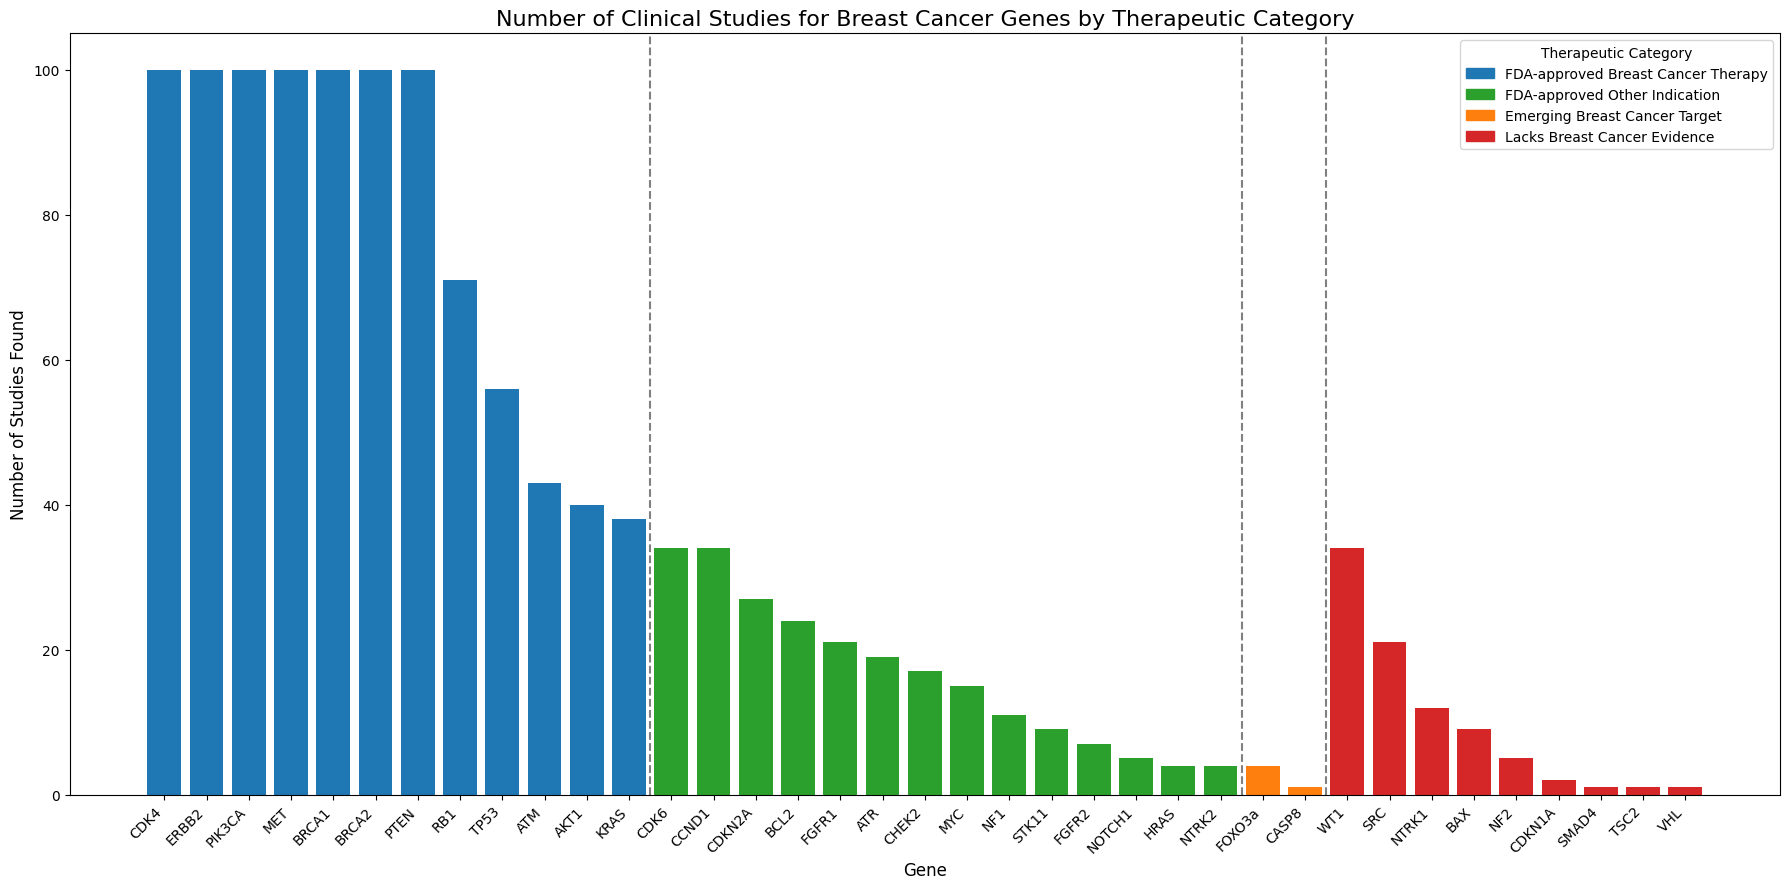

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the data with the final, updated study counts.
# NOTE: To avoid the ValueError, all lists must have the same length.
# Each gene is now assigned to a single, final category for clear visualization.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'BAX', 'WT1', 'CDKN1A', 'SRC', 'NF2', 'NTRK1', 'SMAD4', 
        'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'studies': [
        100, 100, 100, 100, 100, 100, 100, 71,
        56, 43, 40, 38, 34, 34, 27, 24, 21, 17,
        19, 15, 11, 9, 7, 5, 4, 4, 9, 34, 2, 21, 5, 12, 1,
        1, 1, 1, 4
    ],
    'category': [
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Emerging Breast Cancer Target',
        'Emerging Breast Cancer Target'
    ]
}

# Create a pandas DataFrame.
df = pd.DataFrame(data)

# Sort the data first by category and then by the number of studies within each category.
category_order = [
    'FDA-approved Breast Cancer Therapy', 
    'FDA-approved Other Indication', 
    'Emerging Breast Cancer Target', 
    'Lacks Breast Cancer Evidence'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'FDA-approved Breast Cancer Therapy': '#1f77b4',  # Blue
    'FDA-approved Other Indication': '#2ca02c',      # Green
    'Emerging Breast Cancer Target': '#ff7f0e',      # Orange
    'Lacks Breast Cancer Evidence': '#d62728'        # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
plt.figure(figsize=(18, 9))
plt.bar(df['gene'], df['studies'], color=colors)

# Add labels and title for clarity.
plt.title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=16)
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Number of Studies Found', fontsize=12)

# Rotate x-axis labels to prevent overlap.
plt.xticks(rotation=45, ha='right')

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    plt.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
plt.legend(handles, category_order, title="Therapeutic Category")

plt.tight_layout()
plt.show()




In [77]:
import plotly.graph_objects as go

# Define the data for the Sankey diagram.
# We will use the same data to build the nodes and links.

# First layer: Genes to Categories
gene_to_category = {
    'CDK4': 'FDA-approved Breast Cancer Therapy',
    'ERBB2': 'FDA-approved Breast Cancer Therapy',
    'PIK3CA': 'FDA-approved Breast Cancer Therapy',
    'MET': 'FDA-approved Breast Cancer Therapy',
    'BRCA1': 'FDA-approved Breast Cancer Therapy',
    'BRCA2': 'FDA-approved Breast Cancer Therapy',
    'PTEN': 'FDA-approved Breast Cancer Therapy',
    'RB1': 'FDA-approved Breast Cancer Therapy',
    'TP53': 'FDA-approved Breast Cancer Therapy',
    'ATM': 'FDA-approved Breast Cancer Therapy',
    'AKT1': 'FDA-approved Breast Cancer Therapy',
    'KRAS': 'FDA-approved Breast Cancer Therapy',
    'CDK6': 'FDA-approved Breast Cancer Therapy',
    'CCND1': 'FDA-approved Other Indication',
    'CDKN2A': 'FDA-approved Other Indication',
    'BCL2': 'FDA-approved Other Indication',
    'FGFR1': 'FDA-approved Other Indication',
    'FGFR2': 'FDA-approved Other Indication',
    'MDM2': 'FDA-approved Other Indication',
    'NF1': 'FDA-approved Other Indication',
    'HRAS': 'FDA-approved Other Indication',
    'NTRK2': 'FDA-approved Other Indication',
    'TSC2': 'FDA-approved Other Indication',
    'STK11': 'FDA-approved Other Indication',
    'ATR': 'FDA-approved Other Indication',
    'NOTCH1': 'FDA-approved Other Indication',
    'SMAD4': 'FDA-approved Other Indication',
    'CHEK2': 'FDA-approved Other Indication',
    'CASP8': 'Emerging Breast Cancer Target',
    'FOXO3a': 'Emerging Breast Cancer Target',
    'CDKN1A': 'Lacks Breast Cancer Evidence',
    'BAX': 'Lacks Breast Cancer Evidence',
    'NRAS': 'Lacks Breast Cancer Evidence',
    'VHL': 'Lacks Breast Cancer Evidence',
    'SRC': 'Lacks Breast Cancer Evidence',
    'NF2': 'Lacks Breast Cancer Evidence',
    'WT1': 'Lacks Breast Cancer Evidence',
    'NTRK1': 'Lacks Breast Cancer Evidence'
}

# Second layer: Drugs associated with genes in the FDA-approved categories
gene_to_drug = {
    'CDK4': 'Palbociclib (Ibrance)',
    'CDK6': 'Palbociclib (Ibrance)',
    'ERBB2': 'Trastuzumab (Herceptin)',
    'PIK3CA': 'Alpelisib (Piqray)',
    'BRCA1': 'Olaparib (Lynparza)',
    'BRCA2': 'Olaparib (Lynparza)',
    'MET': 'Crizotinib (Xalkori)',
    'PTEN': 'Alpelisib (Piqray)',  # Drug for PIK3CA pathway
    'KRAS': 'Sotorasib (Lumakras)',
    'BCL2': 'Venetoclax (Venclexta)',
    'NTRK2': 'Larotrectinib (Vitrakvi)',
    'EGFR': 'Gefitinib (Iressa)',
    'TP53': 'Therapies for TP53' # As there is no single FDA-approved drug
}

# Combine all unique genes, categories, and drugs into a single list of labels
all_labels = list(gene_to_category.keys()) + sorted(list(set(gene_to_category.values()))) + sorted(list(set(gene_to_drug.values())))
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Build source, target, and value lists for the links
source = []
target = []
value = []
link_color = []

# Define colors for the links based on the categories
category_colors = {
    'FDA-approved Breast Cancer Therapy': 'rgba(31, 119, 180, 0.8)',  # Blue
    'FDA-approved Other Indication': 'rgba(44, 160, 44, 0.8)',      # Green
    'Emerging Breast Cancer Target': 'rgba(255, 127, 14, 0.8)',      # Orange
    'Lacks Breast Cancer Evidence': 'rgba(214, 39, 40, 0.8)'        # Red
}

# --- First layer of links: Genes to Categories ---
for gene, category in gene_to_category.items():
    source.append(label_to_index[gene])
    target.append(label_to_index[category])
    value.append(1)
    link_color.append(category_colors[category])

# --- Second layer of links: Genes to Drugs (for approved categories) ---
for gene, drug in gene_to_drug.items():
    # Only link genes from the FDA-approved categories to drugs
    if gene_to_category.get(gene) in ['FDA-approved Breast Cancer Therapy', 'FDA-approved Other Indication']:
        source.append(label_to_index[gene])
        target.append(label_to_index[drug])
        value.append(1)
        link_color.append(category_colors[gene_to_category[gene]])


# Create the Sankey diagram figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        # Set node colors based on category
        color=[
            category_colors.get(gene_to_category.get(label), 'lightgray')
            for label in all_labels
        ],
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_color
    )
)])

fig.update_layout(
    title_text="Flow of Genes from Discovery to Clinical Application",
    font_size=10,
    height=800,
    width=1200
)

fig.show()

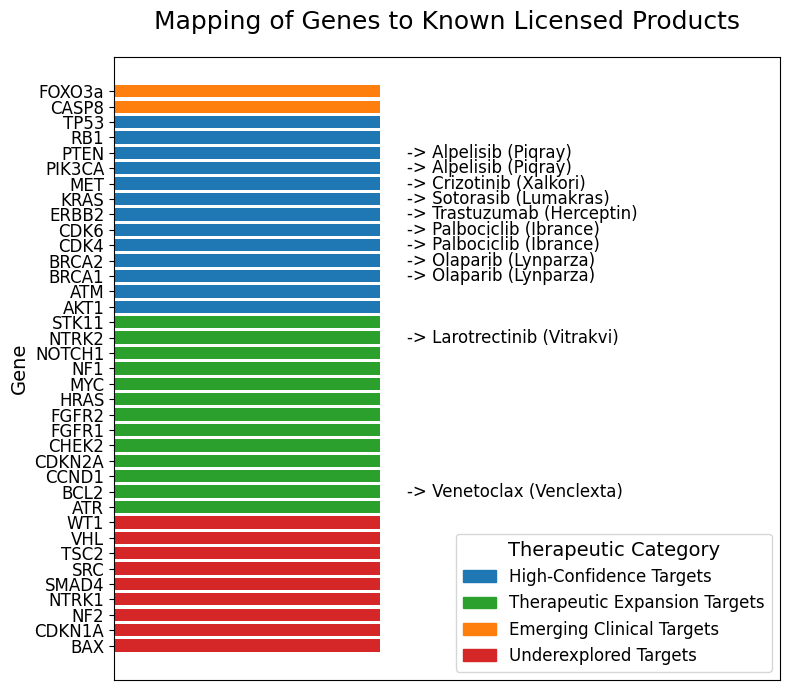

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Data Preparation ---

# Define the genes and their final, validated categories and licensed products.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'CDKN1A', 'BAX', 'SRC', 'NF2', 'WT1', 'NTRK1', 
        'SMAD4', 'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'category': [
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Emerging Clinical Targets',
        'Emerging Clinical Targets'
    ],
    'drug': [
        'Palbociclib (Ibrance)', 'Trastuzumab (Herceptin)', 'Alpelisib (Piqray)', 
        'Crizotinib (Xalkori)', 'Olaparib (Lynparza)', 'Olaparib (Lynparza)', 
        'Alpelisib (Piqray)', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'Sotorasib (Lumakras)',
        'Palbociclib (Ibrance)', 'No Specific Drug', 'No Specific Drug', 
        'Venetoclax (Venclexta)', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'Larotrectinib (Vitrakvi)', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug',
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug'
    ]
}

# Create a DataFrame from the data.
df = pd.DataFrame(data)

# Sort the DataFrame for a logical flow in the plot.
df = df.sort_values(by='category', ascending=True)
df = df.sort_values(by=['category', 'gene'], ascending=[False,True])


# Create a color map for the plot based on your four categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# --- Create the Plot ---
plt.figure(figsize=(8, 7))
# The bar height is a placeholder to control bar order.
plt.barh(df['gene'], [1] * len(df), color=colors)  

# Add text labels for the drug names.
for i, (gene, drug) in enumerate(zip(df['gene'], df['drug'])):
    if drug != 'No Specific Drug':
        plt.text(1.1, i, f'-> {drug}', va='center', fontsize=12, color='black')

# Set labels, title, and other plot aesthetics.
plt.title('Mapping of Genes to Known Licensed Products', fontsize=18, pad=20)
plt.xlabel('Category & Drug Status', fontsize=14)
plt.ylabel('Gene', fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(0, 2.5)  # Adjust x-limit to make space for the drug names
plt.gca().get_xaxis().set_visible(False)  # Hide x-axis

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_colors]
plt.legend(handles, category_colors.keys(), title="Therapeutic Category", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

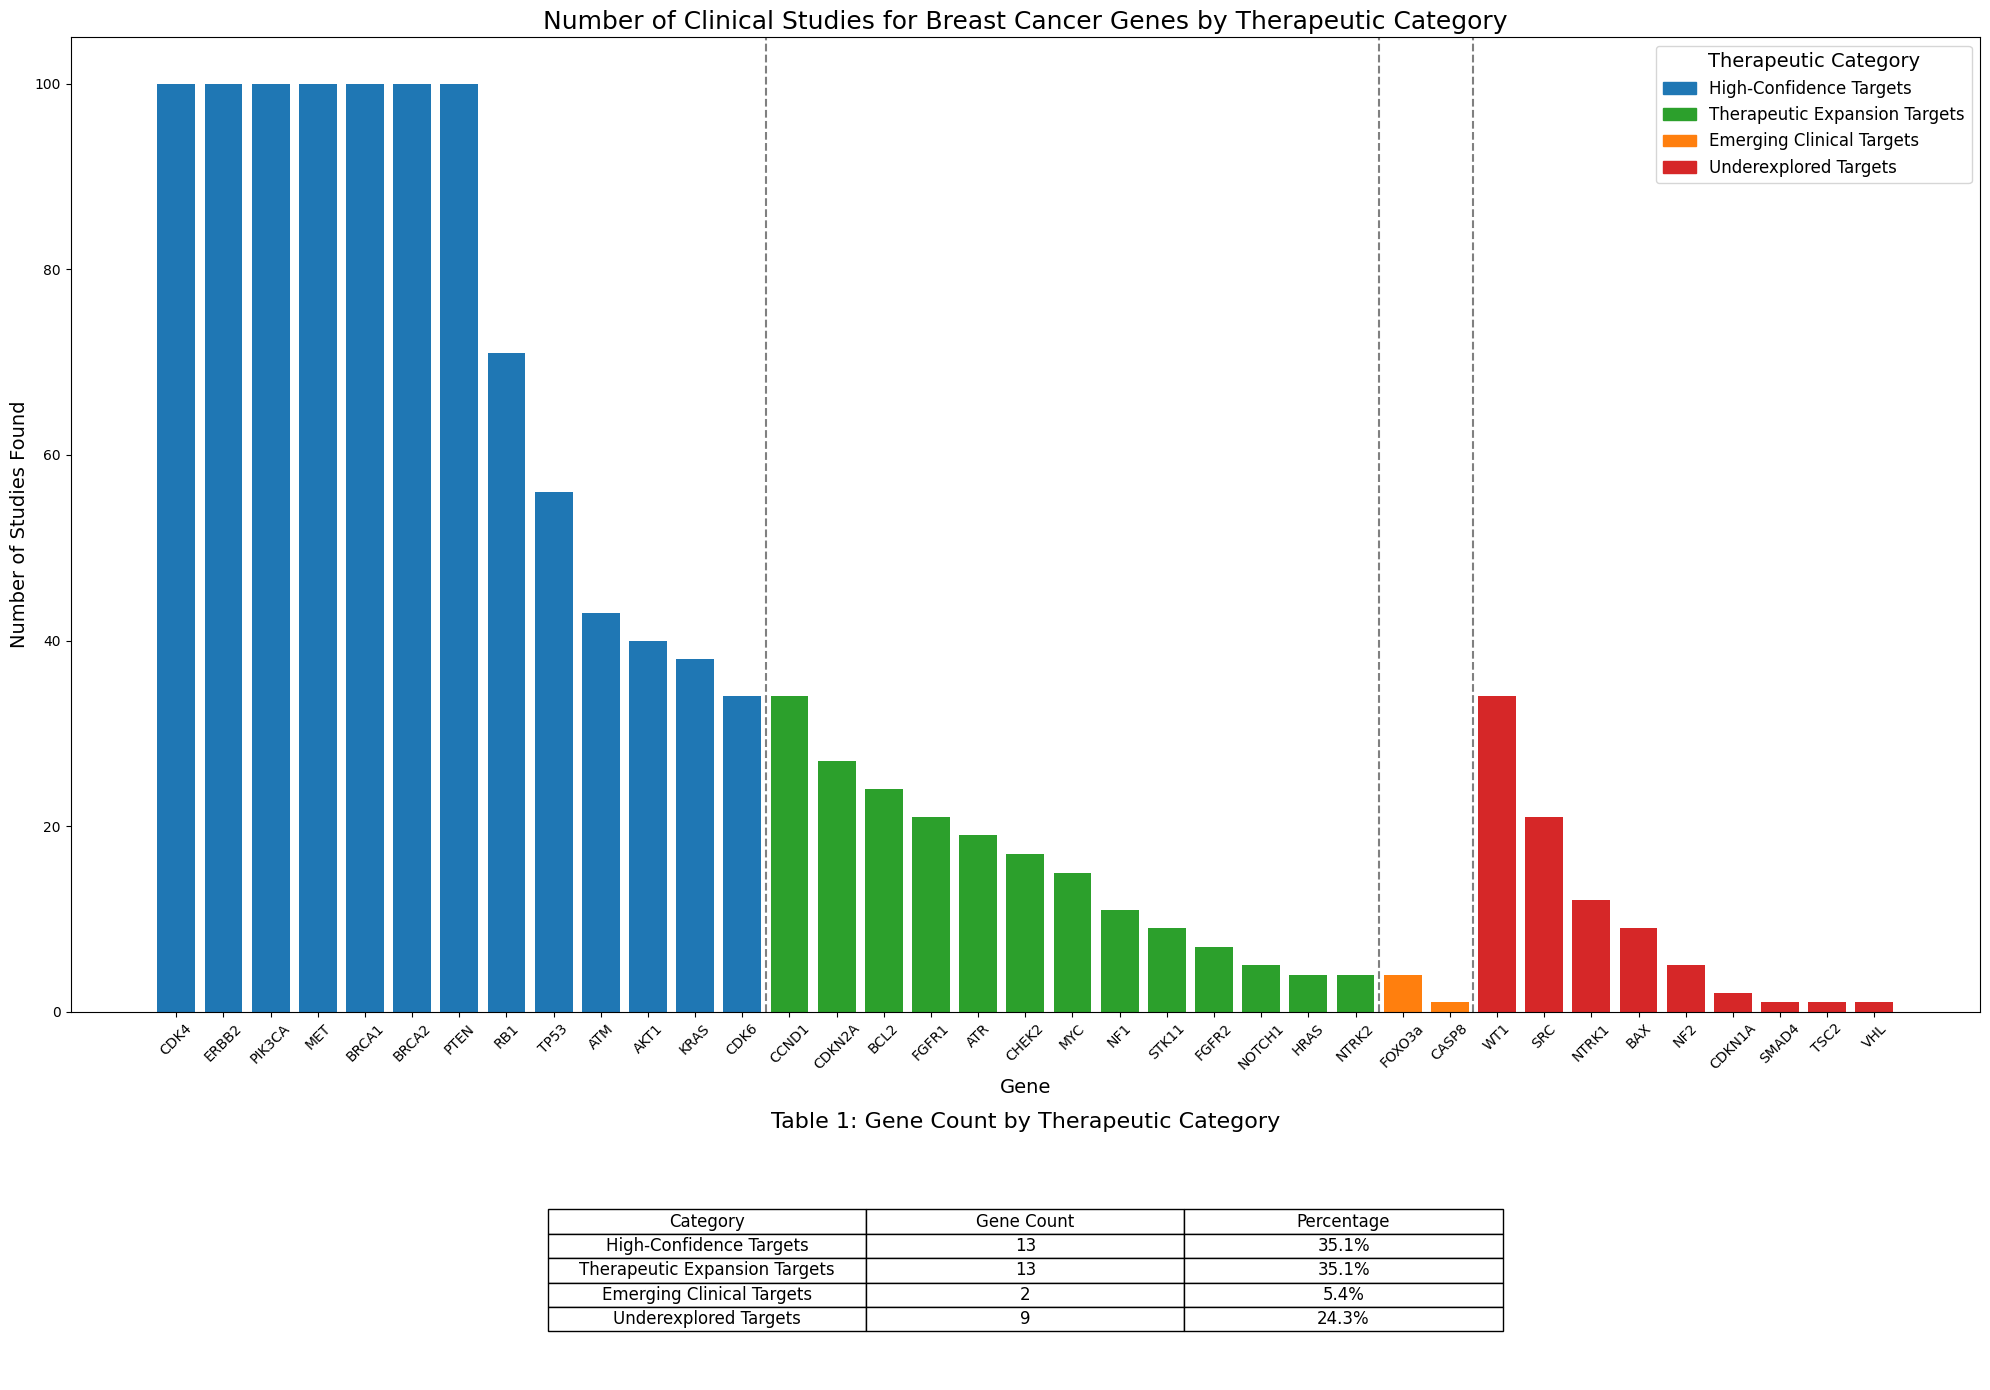

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the data with the final, updated study counts and the four new, precise categories.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'CDKN1A', 'BAX', 'SRC', 'NF2', 'WT1', 'NTRK1', 
        'SMAD4', 'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'studies': [
        100, 100, 100, 100, 100, 100, 100, 71,
        56, 43, 40, 38, 34, 34, 27, 24, 21, 17,
        19, 15, 11, 9, 7, 5, 4, 4, 2, 9, 21, 5, 34, 12,
        1, 1, 1, 1, 4
    ],
    'category': [
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Emerging Clinical Targets',
        'Emerging Clinical Targets'
    ]
}

# Create a pandas DataFrame.
df = pd.DataFrame(data)

# Sort the data first by category order and then by study count within each category.
category_order = [
    'High-Confidence Targets', 
    'Therapeutic Expansion Targets', 
    'Emerging Clinical Targets', 
    'Underexplored Targets'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14), gridspec_kw={'height_ratios': [1, 0.25]})

# Plot the bar chart on the first axes (ax1).
ax1.bar(df['gene'], df['studies'], color=colors)
ax1.set_title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=18)
ax1.set_xlabel('Gene', fontsize=14)
ax1.set_ylabel('Number of Studies Found', fontsize=14)

# Corrected plt.xticks to remove the problematic 'ha' keyword
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    ax1.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
ax1.legend(handles, category_order, title="Therapeutic Category", fontsize=12, title_fontsize=14)

# --- Create the supplementary table on the second axes (ax2) ---
ax2.set_title('Table 1: Gene Count by Therapeutic Category', fontsize=16)
ax2.axis('off') # Hide axes for the table

# Calculate the count and percentage for each category.
category_counts = df['category'].value_counts().to_frame().reset_index()
category_counts.columns = ['Category', 'Gene Count']
total_genes = category_counts['Gene Count'].sum()
category_counts['Percentage'] = (category_counts['Gene Count'] / total_genes * 100).round(1).astype(str) + '%'

# Reorder the table to match the plot.
category_counts['Category'] = pd.Categorical(category_counts['Category'], categories=category_order, ordered=True)
category_counts = category_counts.sort_values(by='Category')

# Create the table
table = ax2.table(cellText=category_counts.values, colLabels=category_counts.columns, cellLoc='center', loc='center', bbox=[0.25, 0.2, 0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()


In [80]:
# import matplotlib.patches as patches

# # Sort df as before
# df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
# df = df.sort_values(by=['category', 'gene'], ascending=[True, True]).reset_index(drop=True)

# plt.figure(figsize=(7, 11))  # Smaller figure size

# ax = plt.gca()

# # Plot bars
# bars = plt.barh(df['gene'], [1] * len(df), color=df['category'].map(category_colors))

# # Add colored blocks with labels behind groups
# current_category = None
# start_idx = 0

# for i, category in enumerate(df['category']):
#     if category != current_category:
#         if current_category is not None:
#             ax.add_patch(
#                 patches.Rectangle(
#                     (0, start_idx - 0.5),
#                     width=1,
#                     height=i - start_idx,
#                     color=category_colors[current_category],
#                     alpha=0.1,
#                     zorder=0
#                 )
#             )
#             ax.text(
#                 -0.1,
#                 (start_idx + i - 1) / 2,
#                 current_category,
#                 va='center',
#                 ha='right',
#                 fontsize=9,
#                 color=category_colors[current_category],
#                 fontweight='bold'
#             )
#         current_category = category
#         start_idx = i

# # Last group rectangle and label
# ax.add_patch(
#     patches.Rectangle(
#         (0, start_idx - 0.5),
#         width=1,
#         height=len(df) - start_idx,
#         color=category_colors[current_category],
#         alpha=0.1,
#         zorder=0
#     )
# )
# ax.text(
#     -0.1,
#     (start_idx + len(df) - 1) / 2,
#     current_category,
#     va='center',
#     ha='right',
#     fontsize=9,
#     color=category_colors[current_category],
#     fontweight='bold'
# )

# # Add drug annotations
# for i, (gene, drug) in enumerate(zip(df['gene'], df['drug'])):
#     if drug != 'No Specific Drug':
#         plt.text(1.05, i, f'-> {drug}', va='center', fontsize=8, color='black')

# # Labels and formatting
# plt.title('Mapping of Genes to Known Licensed Products', fontsize=12, pad=12)
# plt.xlabel('Category & Drug Status', fontsize=10)
# plt.ylabel('Gene', fontsize=10)
# plt.yticks(fontsize=8)
# plt.xlim(-0.5, 2.5)
# plt.gca().get_xaxis().set_visible(False)

# # Legend
# handles = [patches.Patch(color=category_colors[label]) for label in category_colors]
# plt.legend(handles, category_colors.keys(), title="Therapeutic Category", fontsize=9, title_fontsize=10)

# plt.tight_layout()
# plt.show()


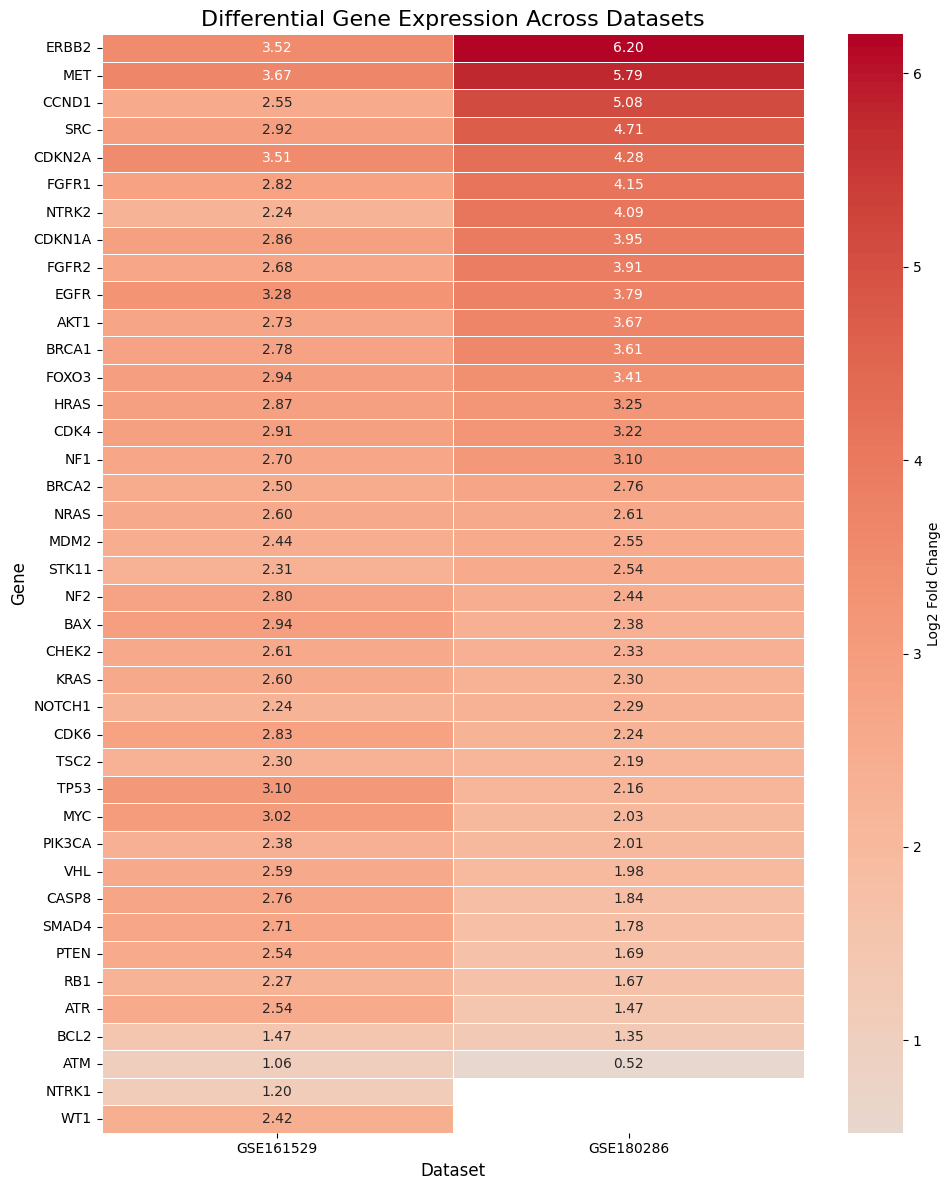

In [82]:
# Sort df_pivot rows by 'GSE180286' column descending

# Pivot the dataframe: index=gene, columns=Dataset, values=log2_fc
df = pd.read_csv(f"{assets}/Combined_DE.csv")
df_pivot = df.pivot(index='gene', columns='Dataset', values='log2_fc')
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

plt.figure(figsize=(10, max(4, len(df_pivot_sorted)*0.3)))  # dynamic height

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Differential Gene Expression Across Datasets', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()


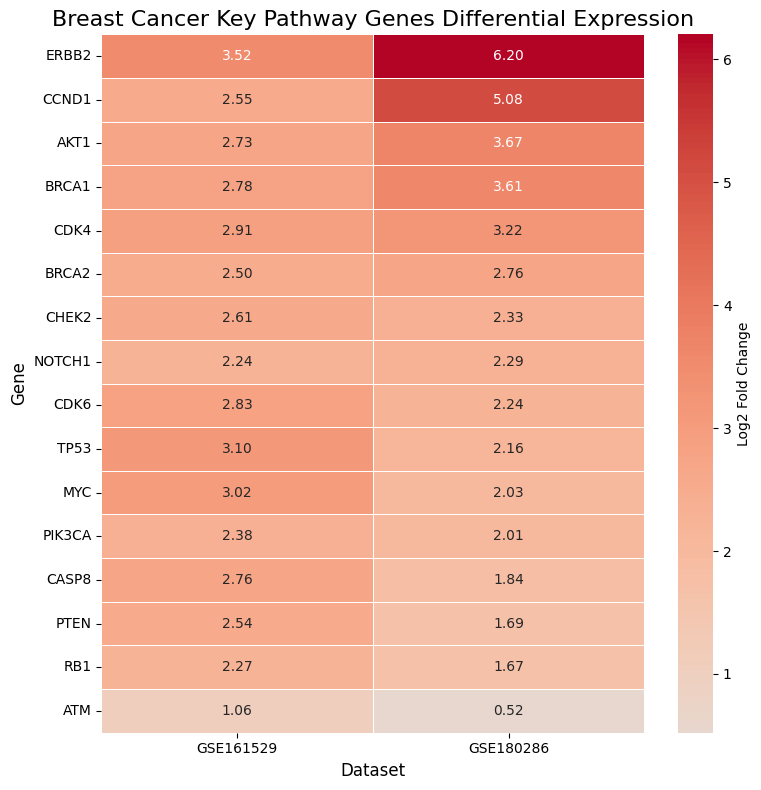

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your core breast cancer genes — you can add more if desired
genes = [
    'ESR1', 'PGR', 'PIK3CA', 'AKT1', 'CDK4', 'CDK6', 'CCND1', 'RB1',
    'PTEN', 'FOXO3a', 'CASP8', 'TP53',
    # Additional important breast cancer genes
    'BRCA1', 'BRCA2', 'MYC', 'HER2', 'ERBB2', 'NOTCH1', 'MTOR', 'CHEK2', 'ATM'
]

# Load your combined DE genes DataFrame
#df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")

# Normalize gene names (optional but recommended)
df['gene_norm'] = df['gene'].str.upper().str.strip()

# Filter for genes of interest (case-insensitive match)
genes_upper = [g.upper() for g in genes]
df_filtered = df[df['gene_norm'].isin(genes_upper)]

# Pivot to get genes as rows, datasets as columns with log2_fc values
df_pivot = df_filtered.pivot(index='gene_norm', columns='Dataset', values='log2_fc')

# Sort by GSE180286 descending
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, max(4, len(df_pivot_sorted)*0.5)))

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Breast Cancer Key Pathway Genes Differential Expression', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()
